## Un aiuto per Airbnb: approcci di Machine Learning per prevedere la destinazione dei nuovi iscritti statunitensi.

Progetto a cura di:



*   Carolla Dario 807547
*   Gaverini Matteo 808101
*   Mariani Paolo 800307



# Caricamento dati e pacchetti

## Mount Drive

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


## Librerie

In [0]:
%tensorflow_version 1.x
!pip install kaggle
!mkdir .kaggle
!pip install pyGPGO
#!pip install -U skater
!pip install ipython-autotime
%load_ext autotime

TensorFlow 1.x selected.
  Created wheel for pyGPGO: filename=pyGPGO-0.4.0.dev1-cp36-none-any.whl size=19866 sha256=3f8fe4c9bb75588ed7c792b7a8987e7328db613352c14c2c1eef98629bf3e774
  Stored in directory: /root/.cache/pip/wheels/d1/27/04/c4fa3bfe194d36e3cd51542132f43415a6813114a5e8301acb
Successfully built pyGPGO
  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=1b3fdb03194523ec69ba61c601cccb212bfef70e5996afad0262fdfec324338b
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime
import dill
import seaborn as sns
from collections import Counter
from datetime import datetime

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# pyGPGO

from pyGPGO.covfunc import squaredExponential
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.RandomForest import RandomForest
from pyGPGO.GPGO import GPGO
from pyGPGO.acquisition import Acquisition

# Keras
import tensorflow as tf
import keras
from keras.layers import Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras import backend as K

# skater
#from skater.core.explanations import Interpretation
#from skater.model import InMemoryModel

# xgboost
from xgboost import XGBClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


time: 4.71 s


Using TensorFlow backend.


## Download API Kaggle

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes
time: 17.8 s


In [0]:
!kaggle competitions download -c airbnb-recruiting-new-user-bookings -p /content

  0% 0.00/1.03M [00:00<?, ?B/s]
100% 1.03M/1.03M [00:00<00:00, 71.8MB/s]
 83% 49.0M/59.1M [00:01<00:00, 37.7MB/s]
100% 59.1M/59.1M [00:01<00:00, 45.4MB/s]
 74% 3.00M/4.07M [00:00<00:00, 15.7MB/s]
100% 4.07M/4.07M [00:00<00:00, 16.2MB/s]
  0% 0.00/546 [00:00<?, ?B/s]
100% 546/546 [00:00<00:00, 566kB/s]
  0% 0.00/2.46k [00:00<?, ?B/s]
100% 2.46k/2.46k [00:00<00:00, 2.24MB/s]
  0% 0.00/478k [00:00<?, ?B/s]
100% 478k/478k [00:00<00:00, 156MB/s]
time: 9.3 s


In [0]:
!unzip sessions.csv.zip
!unzip test_users.csv.zip
!unzip train_users_2.csv.zip

!rm sessions.csv.zip
!rm test_users.csv.zip
!rm train_users_2.csv.zip

Archive:  sessions.csv.zip
  inflating: sessions.csv            
Archive:  test_users.csv.zip
  inflating: test_users.csv          
Archive:  train_users_2.csv.zip
  inflating: train_users_2.csv       
time: 22 s


# Train set (train_users_2) e Test set (test_users)

In [0]:
train = pd.read_csv('train_users_2.csv')
test = pd.read_csv('test_users.csv')
train.tail()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
213446,zxodksqpep,2014-06-30,20140630235636,NaN,MALE,32.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF
213447,mhewnxesx9,2014-06-30,20140630235719,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF
213448,6o3arsjbb4,2014-06-30,20140630235754,NaN,-unknown-,32.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF
213449,jh95kwisub,2014-06-30,20140630235822,NaN,-unknown-,NaN,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari,NDF
213450,nw9fwlyb5f,2014-06-30,20140630235824,NaN,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF


time: 667 ms


In [0]:
# differenze tra train e test
print(np.setdiff1d(train.columns, test.columns, assume_unique=True))

['country_destination']
time: 1.7 ms


In [0]:
# Concatenzazione di train e test per lo stesso preprocessing
all_data = pd.concat([train.drop('country_destination', axis=1), test])
all_data.dtypes

# Trasformazione country destination in numerico (in train)
le = LabelEncoder()
train_labels = le.fit_transform(train.country_destination)
target_labels = pd.Series(train_labels, name='target')
list(le.classes_)

['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US', 'other']

time: 159 ms


## Analisi e Preprocessing train e test

In [0]:
# Variabili numeriche
all_data.describe()

,timestamp_first_active,age,signup_flow
count,2.755470e+05,158681.000000,275547.000000
mean,2.013310e+13,47.145310,4.291965
std,9.146438e+09,142.629468,8.794313
min,2.009032e+13,1.000000,0.000000
25%,2.013040e+13,28.000000,0.000000
50%,2.014010e+13,33.000000,0.000000
75%,2.014062e+13,42.000000,1.000000
max,2.014093e+13,2014.000000,25.000000


time: 120 ms


### Date

All'interno del dataset sono presenti tre date:
- date_account_created (data)
- timestamp_first_active (timestamp)
- date_first_booking (non presente in test)

In [0]:
# Conversione date in datetime
all_data.date_account_created = pd.to_datetime(all_data.date_account_created)
all_data.timestamp_first_active = pd.to_datetime((all_data.timestamp_first_active //1000000 ), format='%Y%m%d')

# drop date_first_booking
all_data.drop('date_first_booking', axis=1, inplace=True)

time: 102 ms


In [0]:
# Controllo valori null
print('Null Values')
print('date_account_created null values: ' + str(all_data.date_account_created.isnull().sum()))
print('timestamp_first_active null values: ' + str(all_data.timestamp_first_active.isnull().sum()))

Null Values
date_account_created null values: 0
timestamp_first_active null values: 0
time: 5.31 ms


Iscrizioni e prime attività AirBnb

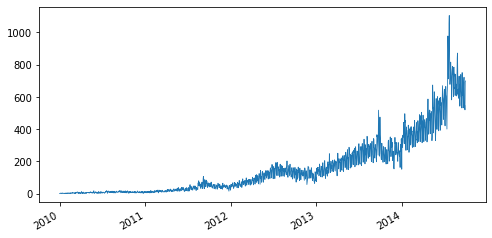

time: 196 ms


In [0]:
plt.figure(figsize=(8, 4))
all_data.date_account_created.value_counts().plot(kind='line', linewidth=0.8)

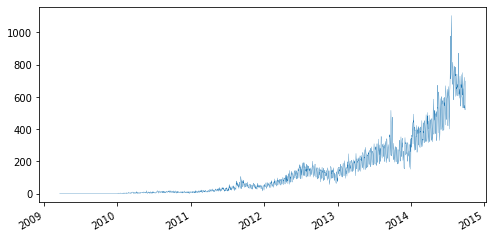

time: 158 ms


In [0]:
plt.figure(figsize=(8, 4))
all_data.timestamp_first_active.value_counts().plot(kind='line', linewidth=0.3)

In [0]:
# timestamp_first_active
all_data['first_active_year'] = all_data.timestamp_first_active.dt.year
all_data['first_active_month'] = all_data.timestamp_first_active.dt.month
all_data['firth_active_month_sin'] = np.sin((all_data.timestamp_first_active.dt.month-1)*(2.*np.pi/12))
all_data['firth_active_month_cos'] = np.cos((all_data.timestamp_first_active.dt.month-1)*(2.*np.pi/12))

# date_account_created
all_data['account_creation_year'] = all_data.date_account_created.dt.year
all_data['account_creation_month'] = all_data.date_account_created.dt.month
all_data['account_creation_month_sin'] = np.sin((all_data.date_account_created.dt.month-1)*(2.*np.pi/12))
all_data['account_creation_month_cos'] = np.cos((all_data.date_account_created.dt.month-1)*(2.*np.pi/12))

time: 275 ms


###gender

In [0]:
all_data["gender"].value_counts()

-unknown-    129480
FEMALE        77524
MALE          68209
OTHER           334
Name: gender, dtype: int64

time: 36.7 ms


In [0]:
# Controllo valori null
print('gender null values: ' + str(all_data.gender.isnull().sum()))

gender null values: 0
time: 15.1 ms


Text(0, 0.5, 'count')

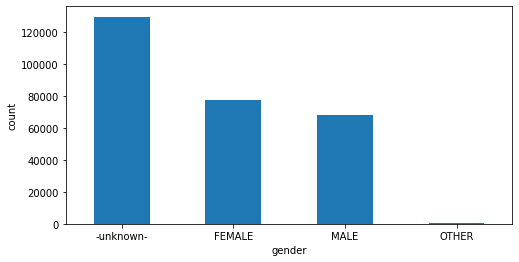

time: 172 ms


In [0]:
plt.figure(figsize=(8, 4))
all_data.gender.value_counts(dropna=False).plot(kind='bar', rot=0)
plt.xlabel('gender')
plt.ylabel('count')

###age

In [0]:
# Controllo valori null
print('age null values: ' + str(all_data.age.isnull().sum()))
print('Il ' + str(all_data.age.isnull().sum() / len(all_data) * 100) + '%' + ' della variabile age è Nan')

age null values: 116866
Il 42.412365222629894% della variabile age è Nan
time: 4.3 ms


Distribuzione della variabile age

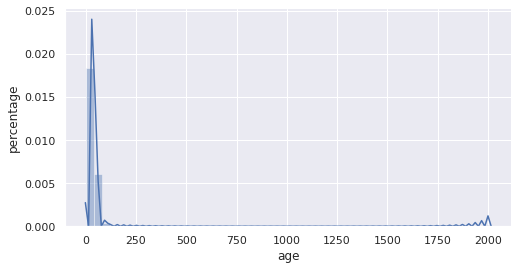

time: 418 ms


In [0]:
sns.set(rc={'figure.figsize':(8,4)})
sns.distplot(all_data.age.dropna())
plt.xlabel('age')
plt.ylabel('percentage')
sns.despine()

Sono presenti molteplici valori errati all'interno della variabile age. 

Vengono sostituiti tutti i valori maggiori di 100 e minori di 18 secondo la politica di AirBnB.

In [0]:
# Controlla possibili date di nascita all'interno della variabile age
def controlla_eta(eta,date):
  if eta > 1920:
    ris = date.year-eta
  else:
    ris = eta
  return ris

all_data['age'] = all_data.apply(lambda x: controlla_eta(x['age'],x['date_account_created']),axis=1)

# variabile age 
all_data.loc[all_data.age > 100, 'age'] = np.nan
all_data.loc[all_data.age < 18, 'age'] = np.nan

time: 8.61 s


In [0]:
all_data.age.fillna(-1, inplace = True)

time: 3.73 ms


In [0]:
# drop delle date (non più necessarie)
all_data.drop('date_account_created', axis = 1, inplace = True)
all_data.drop('timestamp_first_active', axis = 1, inplace = True)

time: 71.3 ms


Nuova distribuzione della variabile age

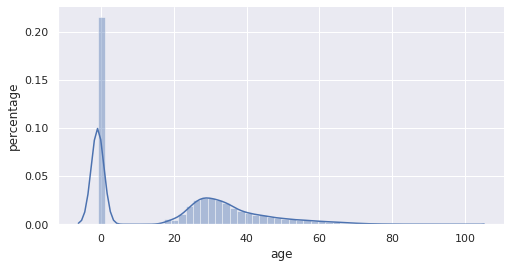

time: 403 ms


In [0]:
sns.set(rc={'figure.figsize':(8,4)})
sns.distplot(all_data.age.dropna())
plt.xlabel('age')
plt.ylabel('percentage')
sns.despine()

### signup_method

In [0]:
# Controllo valori null
print('signup_method null values: ' + str(all_data.signup_method.isnull().sum()))

signup_method null values: 0
time: 15.1 ms


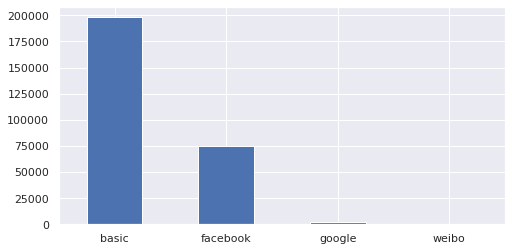

time: 197 ms


In [0]:
plt.figure(figsize=(8, 4))
all_data.signup_method.value_counts(dropna=False).plot(kind='bar', rot=0)

###signup_flow

In [0]:
# Controllo valori null
print('signup_flow null values: ' + str(all_data.signup_flow.isnull().sum()))

signup_flow null values: 0
time: 2.74 ms


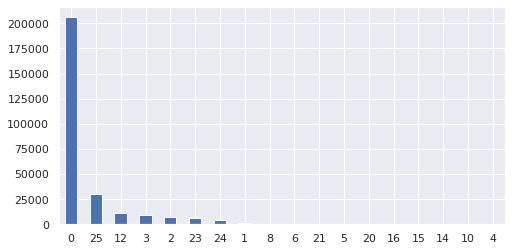

time: 293 ms


In [0]:
plt.figure(figsize=(8, 4))
all_data.signup_flow.value_counts(dropna=False).plot(kind='bar', rot=0)

###language

In [0]:
# Controllo valori null
print('language null values: ' + str(all_data.language.isnull().sum()))

language null values: 0
time: 14.3 ms


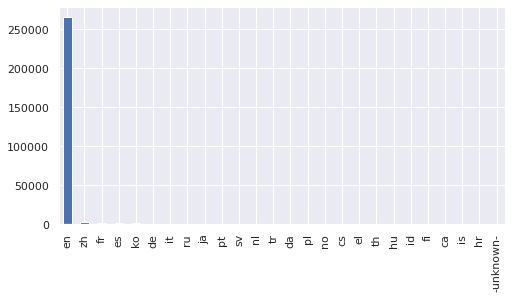

time: 323 ms


In [0]:
plt.figure(figsize=(8, 4))
all_data.language.value_counts(dropna=False).plot(kind='bar', rot=0)
plt.xticks(rotation='vertical')
plt.show()

###affiliate_channel

In [0]:
# Controllo valori null
print('affiliate_channel null values: ' + str(all_data.affiliate_channel.isnull().sum()))

affiliate_channel null values: 0
time: 15.1 ms


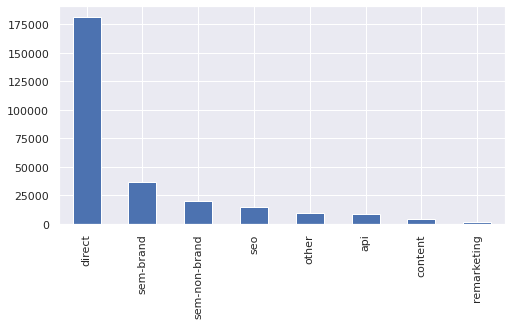

time: 211 ms


In [0]:
plt.figure(figsize=(8, 4))
all_data.affiliate_channel.value_counts(dropna=False).plot(kind='bar', rot=0)
plt.xticks(rotation='vertical')
plt.show()

###affiliate_provider

In [0]:
# Controllo valori null
print('affiliate_provider null values: ' + str(all_data.affiliate_provider.isnull().sum()))

affiliate_provider null values: 0
time: 19.6 ms


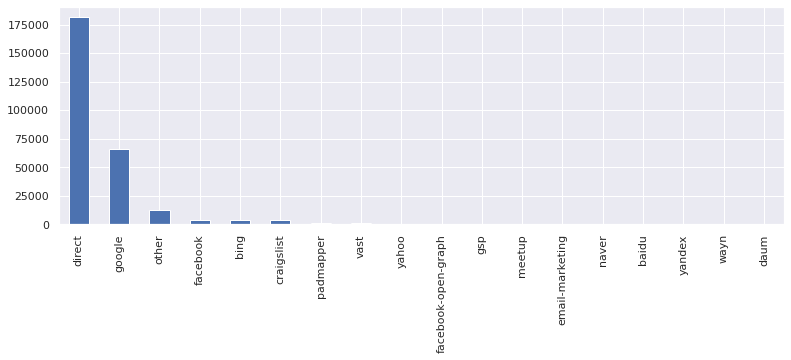

time: 294 ms


In [0]:
plt.figure(figsize=(13, 4))
all_data.affiliate_provider.value_counts(dropna=False).plot(kind='bar', rot=0)
plt.xticks(rotation='vertical')
plt.show()

###first_affiliate_tracked

In [0]:
# Controllo valori null
print('first_affiliate_tracked null values: ' + str(all_data.first_affiliate_tracked.isnull().sum()))
print('Il ' + str(all_data.first_affiliate_tracked.isnull().sum() / len(all_data) * 100) + '%' + ' della variabile age è Nan')

first_affiliate_tracked null values: 6085
Il 2.208334694262685% della variabile age è Nan
time: 29.2 ms


Sostituzione Nan in base ai valori di affiliate_channel

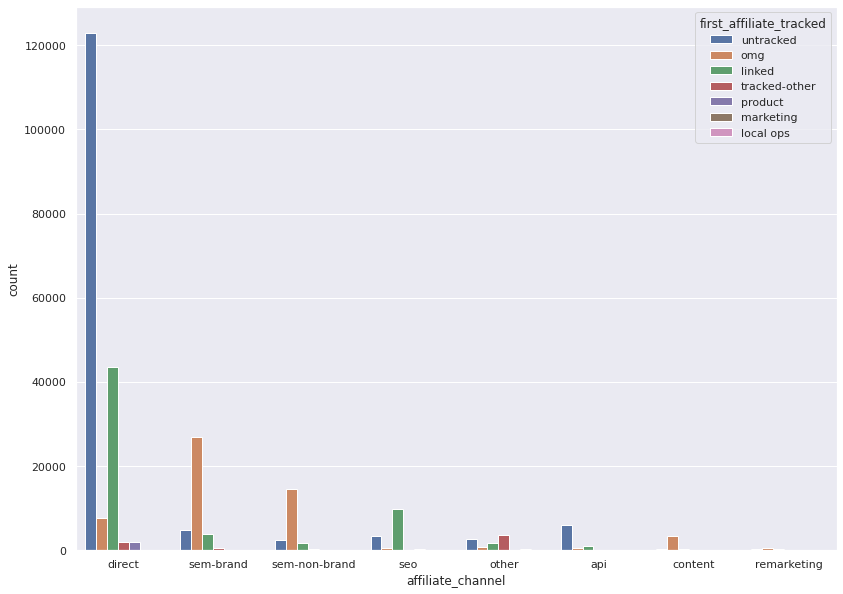

time: 855 ms


In [0]:
plt.figure(figsize=(30,10))
plt.subplot(121)
top_browsers = all_data.groupby('affiliate_channel').id.count().nlargest(8).index
df = all_data.dropna(subset=['affiliate_channel']).copy()
df.affiliate_channel = df.affiliate_channel.apply(lambda browser: 'Other' if browser not in top_browsers else browser)
sns.countplot(x = 'affiliate_channel', data = df, hue='first_affiliate_tracked' ,order=df.affiliate_channel.value_counts().index)
plt.legend(title='first_affiliate_tracked', loc='upper right')
plt.show()

In [0]:
# sostituzione dei valori null in base ai valori di affiliate_channel
all_data.loc[(all_data.first_affiliate_tracked.isnull()) & 
            ((all_data.affiliate_channel == 'direct') | 
            (all_data.affiliate_channel == 'api')), 'first_affiliate_tracked'] = 'untracked'

all_data.loc[(all_data.first_affiliate_tracked.isnull()) &
            ((all_data.affiliate_channel == 'sem-brand') |
            (all_data.affiliate_channel == 'sem-non-brand') |
            (all_data.affiliate_channel == 'content') |
            (all_data.affiliate_channel == 'remarketing')), 'first_affiliate_tracked'] = 'omg'

all_data.loc[(all_data.first_affiliate_tracked.isnull()) &
             (all_data.affiliate_channel == 'seo'), 'first_affiliate_tracked'] = 'linked'

all_data.loc[(all_data.first_affiliate_tracked.isnull()) &
             (all_data.affiliate_channel == 'other'), 'first_affiliate_tracked'] = 'tracked-other'

print('valori null di first_affiliate_tracked dopo il replace: ' + str(all_data.first_affiliate_tracked.isnull().sum()))

valori null di first_affiliate_tracked dopo il replace: 0
time: 204 ms


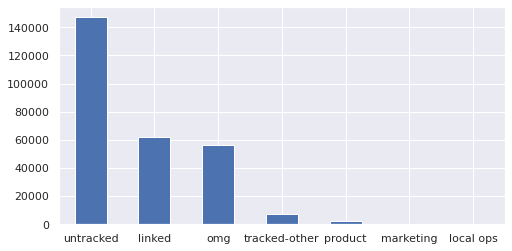

time: 224 ms


In [0]:
plt.figure(figsize=(8, 4))
all_data.first_affiliate_tracked.value_counts(dropna=False).plot(kind='bar', rot=0)

###signup_app

In [0]:
# Controllo valori null
print('signup_app null values: ' + str(all_data.signup_app.isnull().sum()))

signup_app null values: 0
time: 14.1 ms


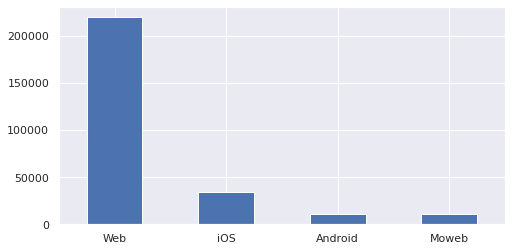

time: 184 ms


In [0]:
all_data.signup_app.value_counts(dropna=False).plot(kind='bar', rot=0)

###first_device_type

In [0]:
# Controllo valori null
print('first_device_type null values: ' + str(all_data.first_device_type.isnull().sum()))

first_device_type null values: 0
time: 14.4 ms


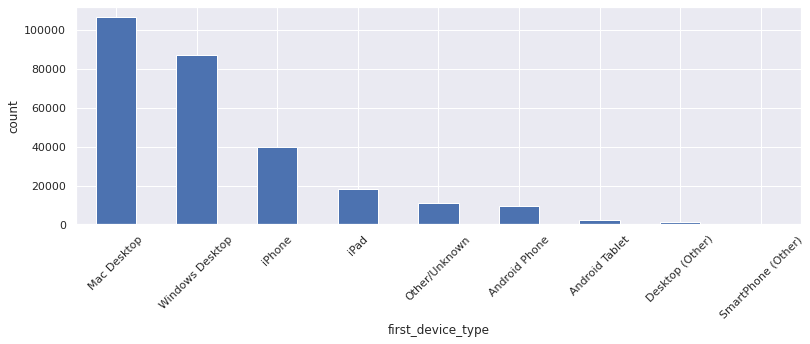

time: 230 ms


In [0]:
plt.figure(figsize=(13, 4))
all_data.first_device_type.value_counts(dropna=False).plot(kind='bar', rot=0)
plt.xticks(rotation=45)
plt.xlabel('first_device_type')
plt.ylabel('count')
plt.show()

###first_browser

In [0]:
# Controllo valori null
print('first_browser null values: ' + str(all_data.first_browser.isnull().sum()))

first_browser null values: 0
time: 17 ms


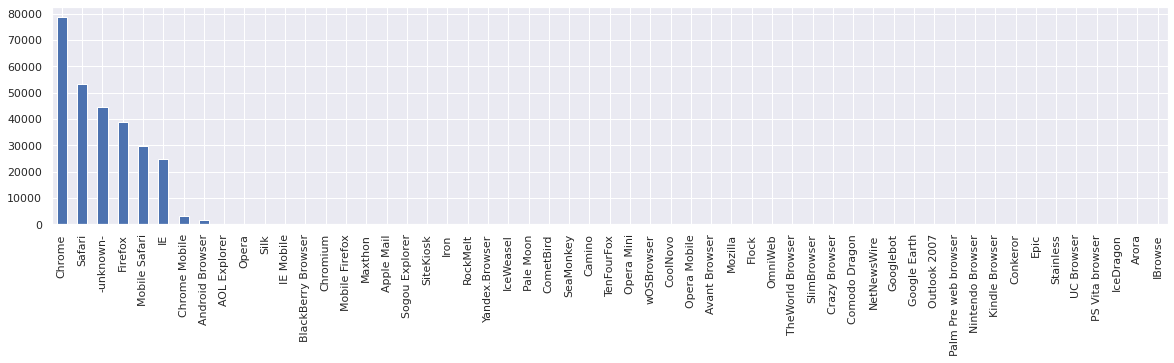

time: 1.74 s


In [0]:
plt.figure(figsize=(20, 4))
all_data.first_browser.value_counts(dropna=False).plot(kind='bar', rot=0)
plt.xticks(rotation='vertical')
plt.show()

###country_destination

Text(0, 0.5, 'count')

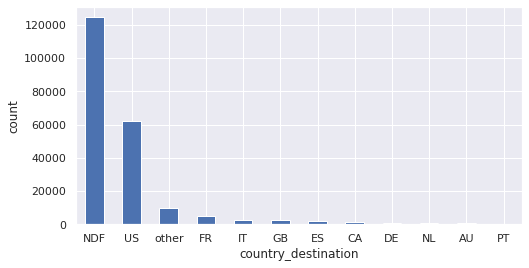

time: 256 ms


In [0]:
plt.figure(figsize=(8, 4))
train.country_destination.value_counts(dropna=False).plot(kind='bar', rot=0)
plt.xlabel('country_destination')
plt.ylabel('count')

# Session

In [0]:
sessions = pd.read_csv('sessions.csv')

time: 8.67 s


In [0]:
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


time: 18.3 ms


In [0]:
# copia di utenti per operazioni
df_session = pd.DataFrame(sessions.user_id.unique())
df_session.columns = ['user_id']
df_session

,user_id
0,d1mm9tcy42
1,yo8nz8bqcq
2,4grx6yxeby
3,ncf87guaf0
4,4rvqpxoh3h
...,...
135479,cv0na2lf5a
135480,zp8xfonng8
135481,fa6260ziny
135482,87k0fy4ugm


time: 377 ms


### action

In [0]:
# Controllo valori null
print('action null values: ' + str(sessions.action.isnull().sum()))

action null values: 79626
time: 435 ms


In [0]:
# Controllo le 'action_type' per le action nulle
sessions[sessions.action.isnull()].action_type.value_counts()

message_post    79626
Name: action_type, dtype: int64

time: 499 ms


Ogni null di action corrisponde a message_post in action type. 

Sostituisco i null con l'azione 'message'

In [0]:
# Sostituisco null con valore "message"
sessions.action.fillna('message', inplace = True)

time: 467 ms


Calcolo il numero totale di azioni effettuate da ogni utente

In [0]:
number_actions_for_user = pd.DataFrame(sessions.groupby(by = 'user_id')['action'].count()).reset_index()
number_actions_for_user.columns = ['user_id', 'number_actions']

# Numero di azioni per utente
number_actions_for_user.head()

,user_id,number_actions
0,00023iyk9l,40
1,0010k6l0om,63
2,001wyh0pz8,90
3,0028jgx1x1,31
4,002qnbzfs5,789


time: 1.26 s


Calcolo, per ogni azione effettuata dall'utente, il numero di volte effettuata

In [0]:
# calcolo per ogni azione il numero di volte che è stata effettuata da un utente
number_for_action = sessions.groupby(by=['user_id','action']).count().sort_values('action_type', ascending = False).reset_index()
# seleziono solo l'azione effettuata più volte da un utente
number_for_action = number_for_action.loc[number_for_action.groupby(by=['user_id'])['action_type'].idxmax()].iloc[:, 0:3]
number_for_action.rename(columns={'action': 'favourite_action', 'action_type': 'number_favourite_action'}, inplace = True)
number_for_action.head()

,user_id,favourite_action,number_favourite_action
334121,00023iyk9l,show,6
154054,0010k6l0om,show,13
14661,001wyh0pz8,search,66
135907,0028jgx1x1,show,15
987,002qnbzfs5,show,225


time: 22.3 s


Calcolo l'ultima azione effettuata dall'utente

In [0]:
last_action = sessions.groupby(by=['user_id']).tail(1)
last_action = last_action[['user_id', 'action']]
last_action.rename(columns = {'action': 'last_action'}, inplace = True)
last_action.head()

,user_id,last_action
126,d1mm9tcy42,show
135,yo8nz8bqcq,show
151,4grx6yxeby,personalize
303,ncf87guaf0,personalize
311,4rvqpxoh3h,index


time: 1.21 s


Calcolo colonna in cui è presente un traslate

In [0]:
translate = sessions.copy()

translate['translate'] = 0

translate.loc[(translate['action']=='ajax_google_translate_description') |
             (translate['action']=='ajax_google_translate') |
             (translate['action']=='ajax_google_translate_reviews'), 'translate'] = 1

translate.drop(columns=['action', 'action_type', 'action_detail', 'device_type', 'secs_elapsed'], inplace = True)

translate = translate.loc[translate.groupby('user_id')['translate'].idxmax()]


time: 20.1 s


Unione delle feature create

In [0]:
df_session = df_session.join(number_actions_for_user.set_index('user_id'), on = 'user_id')
df_session = df_session.join(number_for_action.set_index('user_id'), on = 'user_id')
df_session = df_session.join(last_action.set_index('user_id'), on = 'user_id')
df_session = df_session.join(translate.set_index('user_id'), on = 'user_id')
df_session.head()

,user_id,number_actions,favourite_action,number_favourite_action,last_action,translate
0,d1mm9tcy42,127.0,personalize,25.0,show,0.0
1,yo8nz8bqcq,9.0,show,2.0,show,0.0
2,4grx6yxeby,16.0,create,4.0,personalize,0.0
3,ncf87guaf0,152.0,ajax_refresh_subtotal,32.0,personalize,0.0
4,4rvqpxoh3h,8.0,index,2.0,index,0.0


time: 299 ms


### action_type


In [0]:
# Controllo valori nulli
print('action_type null values: ' + str(sessions.action_type.isnull().sum()))

action_type null values: 1126204
time: 432 ms


In [0]:
sistemare = sessions[sessions['action_type'].isnull()==True]
action = list(sistemare['action'].unique())
no_sistemare = sessions.drop(index=sistemare.index,axis=0)

time: 1.55 s


In [0]:
def estrai_moda(sessions, feature, action):
  ris = sessions[sessions['action']==action][feature].mode()
  if len(ris)==0:
    moda = 'Nan'
  else:
    moda = ris[0]
  return moda
  
import functools
moda = list(map(functools.partial(estrai_moda, sessions, 'action_type'), action))
dict_action = dict(zip(action,moda))
sistemare['action_type']=sistemare['action'].apply(lambda x: dict_action[x])
sessions = pd.concat([no_sistemare,sistemare],axis=0).reindex(sessions.index)
sessions.loc[sessions['action_type'] == 'Nan', 'action_type'] = sessions['action_type'].mode()[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


time: 14.9 s


Calcolo il numero totale di action_type effettuate da ogni utente

In [0]:
number_action_type_for_user = pd.DataFrame(sessions.groupby(by = 'user_id')['action_type'].count()).reset_index()
number_action_type_for_user.columns = ['user_id', 'number_action_type']

# Numero di azioni per utente
number_action_type_for_user.head()

,user_id,number_action_type
0,00023iyk9l,40
1,0010k6l0om,63
2,001wyh0pz8,90
3,0028jgx1x1,31
4,002qnbzfs5,789


time: 1.24 s


Action_type più effettuata dall'utente

In [0]:
# calcolo per ogni azione il numero di volte che è stata effettuata da un utente
number_for_action_type = sessions.groupby(by=['user_id','action_type']).count().sort_values('action_detail', ascending = False).reset_index()
# seleziono solo l'azione effettuata più volte da un utente
number_for_action_type = number_for_action_type.loc[number_for_action_type.groupby(by=['user_id'])['action_detail'].idxmax(), ['user_id', 'action_type', 'action_detail']]
number_for_action_type.rename(columns={'action_type': 'favourite_action_type', 'action_detail': 'number_favourite_action_type'}, inplace = True)
number_for_action_type.head()

,user_id,favourite_action_type,number_favourite_action_type
120809,00023iyk9l,view,21
141713,0010k6l0om,view,17
26561,001wyh0pz8,click,66
162546,0028jgx1x1,view,15
2031,002qnbzfs5,view,216


time: 20.7 s


Calcolo l'ultima action_type effettuata dall'utente

In [0]:
last_action_type = sessions.groupby(by=['user_id']).tail(1)
last_action_type = last_action_type[['user_id', 'action_type']]
last_action_type.rename(columns = {'action_type': 'last_action_type'}, inplace = True)
last_action_type.head()

,user_id,last_action_type
126,d1mm9tcy42,view
135,yo8nz8bqcq,view
151,4grx6yxeby,data
303,ncf87guaf0,data
311,4rvqpxoh3h,-unknown-


time: 1.23 s


Unione delle feature create

In [0]:
df_session = df_session.join(number_action_type_for_user.set_index('user_id'), on = 'user_id')
df_session = df_session.join(number_for_action_type.set_index('user_id'), on = 'user_id')
df_session = df_session.join(last_action_type.set_index('user_id'), on = 'user_id')
df_session.head()

,user_id,number_actions,favourite_action,number_favourite_action,last_action,translate,number_action_type,favourite_action_type,number_favourite_action_type,last_action_type
0,d1mm9tcy42,127.0,personalize,25.0,show,0.0,127.0,data,35.0,view
1,yo8nz8bqcq,9.0,show,2.0,show,0.0,9.0,view,3.0,view
2,4grx6yxeby,16.0,create,4.0,personalize,0.0,16.0,-unknown-,7.0,data
3,ncf87guaf0,152.0,ajax_refresh_subtotal,32.0,personalize,0.0,152.0,click,64.0,data
4,4rvqpxoh3h,8.0,index,2.0,index,0.0,8.0,-unknown-,8.0,-unknown-


time: 233 ms


### action_detail

In [0]:
# Controllo valori nulli
print('action_detail null values: ' + str(sessions.action_detail.isnull().sum()))

action_detail null values: 1126204
time: 434 ms


Sostituzione dei valori null con la moda basata su action

In [0]:
sistemare = sessions[sessions['action_detail'].isnull()==True]
action = list(sistemare['action'].unique())
no_sistemare = sessions.drop(index=sistemare.index,axis=0)

time: 1.67 s


In [0]:
import functools
moda = list(map(functools.partial(estrai_moda, sessions, 'action_detail'), action))
dict_action = dict(zip(action,moda))
sistemare['action_detail']=sistemare['action'].apply(lambda x: dict_action[x])
sessions = pd.concat([no_sistemare,sistemare],axis=0).reindex(sessions.index)
sessions.loc[sessions['action_detail'] == 'Nan', 'action_detail'] = sessions['action_detail'].mode()[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


time: 14.5 s


Calcolo il numero totale di action_detail effettuate da ogni utente

In [0]:
number_action_detail_for_user = pd.DataFrame(sessions.groupby(by = 'user_id')['action_detail'].count()).reset_index()
number_action_detail_for_user.columns = ['user_id', 'number_action_detail']

# Numero di azioni per utente
number_action_detail_for_user.head()

,user_id,number_action_detail
0,00023iyk9l,40
1,0010k6l0om,63
2,001wyh0pz8,90
3,0028jgx1x1,31
4,002qnbzfs5,789


time: 1.27 s


Action_type più effettuata dall'utente

In [0]:
# calcolo per ogni azione il numero di volte che è stata effettuata da un utente
number_for_action_detail = sessions.groupby(by=['user_id','action_detail']).count().sort_values('action_type', ascending = False).reset_index()
# seleziono solo l'azione effettuata più volte da un utente
number_for_action_detail = number_for_action_detail.loc[number_for_action_detail.groupby(by=['user_id'])['action_type'].idxmax(), ['user_id', 'action_detail', 'action_type']]
number_for_action_detail.rename(columns={'action_detail': 'favourite_action_detail', 'action_type': 'number_favourite_action_detail'}, inplace = True)
number_for_action_detail.head()

,user_id,favourite_action_detail,number_favourite_action_detail
260818,00023iyk9l,p3,9
78298,0010k6l0om,p3,28
19741,001wyh0pz8,view_search_results,66
260785,0028jgx1x1,view_search_results,9
1480,002qnbzfs5,-unknown-,212


time: 22.2 s


Calcolo l'ultima action_type effettuata dall'utente

In [0]:
last_action_detail = sessions.groupby(by=['user_id']).tail(1)
last_action_detail = last_action_detail[['user_id', 'action_detail']]
last_action_detail.rename(columns = {'action_detail': 'last_action_detail'}, inplace = True)
last_action_detail.head()

,user_id,last_action_detail
126,d1mm9tcy42,p3
135,yo8nz8bqcq,p3
151,4grx6yxeby,wishlist_content_update
303,ncf87guaf0,wishlist_content_update
311,4rvqpxoh3h,-unknown-


time: 1.2 s


Unione delle feature create

In [0]:
df_session = df_session.join(number_action_detail_for_user.set_index('user_id'), on = 'user_id')
df_session = df_session.join(number_for_action_detail.set_index('user_id'), on = 'user_id')
df_session = df_session.join(last_action_detail.set_index('user_id'), on = 'user_id')
df_session.head()

,user_id,number_actions,favourite_action,number_favourite_action,last_action,translate,number_action_type,favourite_action_type,number_favourite_action_type,last_action_type,number_action_detail,favourite_action_detail,number_favourite_action_detail,last_action_detail
0,d1mm9tcy42,127.0,personalize,25.0,show,0.0,127.0,data,35.0,view,127.0,p3,51.0,p3
1,yo8nz8bqcq,9.0,show,2.0,show,0.0,9.0,view,3.0,view,9.0,p3,2.0,p3
2,4grx6yxeby,16.0,create,4.0,personalize,0.0,16.0,-unknown-,7.0,data,16.0,-unknown-,7.0,wishlist_content_update
3,ncf87guaf0,152.0,ajax_refresh_subtotal,32.0,personalize,0.0,152.0,click,64.0,data,152.0,p3,35.0,wishlist_content_update
4,4rvqpxoh3h,8.0,index,2.0,index,0.0,8.0,-unknown-,8.0,-unknown-,8.0,-unknown-,8.0,-unknown-


time: 256 ms


### device_type

In [0]:
# Controllo valori nulli
print('action_detail null values: ' + str(sessions.action_detail.isnull().sum()))

action_detail null values: 0
time: 427 ms


Creo colonna con device più utilizzato (per più tempo)

In [0]:
device_type = pd.DataFrame(sessions.groupby(['user_id', 'device_type'])['secs_elapsed'].sum()).reset_index()
device_type = device_type.loc[device_type.groupby('user_id')['secs_elapsed'].idxmax()].reset_index(drop = True)
device_type.drop('secs_elapsed', axis = 1, inplace = True)
device_type.rename(columns = {'device_type': 'favourite_device_type'}, inplace = True)
device_type.head()

,user_id,favourite_device_type
0,00023iyk9l,iPhone
1,0010k6l0om,Mac Desktop
2,001wyh0pz8,Android App Unknown Phone/Tablet
3,0028jgx1x1,-unknown-
4,002qnbzfs5,iPhone


time: 24.6 s


Unione delle feature create

In [0]:
df_session = df_session.join(device_type.set_index('user_id'), on = 'user_id')
df_session.head()

,user_id,number_actions,favourite_action,number_favourite_action,last_action,translate,number_action_type,favourite_action_type,number_favourite_action_type,last_action_type,number_action_detail,favourite_action_detail,number_favourite_action_detail,last_action_detail,favourite_device_type
0,d1mm9tcy42,127.0,personalize,25.0,show,0.0,127.0,data,35.0,view,127.0,p3,51.0,p3,Windows Desktop
1,yo8nz8bqcq,9.0,show,2.0,show,0.0,9.0,view,3.0,view,9.0,p3,2.0,p3,Mac Desktop
2,4grx6yxeby,16.0,create,4.0,personalize,0.0,16.0,-unknown-,7.0,data,16.0,-unknown-,7.0,wishlist_content_update,Windows Desktop
3,ncf87guaf0,152.0,ajax_refresh_subtotal,32.0,personalize,0.0,152.0,click,64.0,data,152.0,p3,35.0,wishlist_content_update,Windows Desktop
4,4rvqpxoh3h,8.0,index,2.0,index,0.0,8.0,-unknown-,8.0,-unknown-,8.0,-unknown-,8.0,-unknown-,iPhone


time: 109 ms


### secs_elapsed

In [0]:
# Controllo valori nulli
print('secs_elapsed null values: ' + str(sessions.secs_elapsed.isnull().sum()))

secs_elapsed null values: 136031
time: 23.5 ms


Sostituizione dei valori null con la mediana del tempo per azione

In [0]:
median_duration = pd.DataFrame(sessions.groupby('action', as_index = False)['secs_elapsed'].median())

time: 957 ms


In [0]:
# Merge dei dataframes con la mediana delle azioni
sessions = sessions.merge(median_duration, left_on = 'action', right_on = 'action', how = 'left')
# se il valore è null, sostituisce con la mediana
sessions.loc[sessions.secs_elapsed_x.isnull(), 'secs_elapsed_x'] = sessions.secs_elapsed_y
sessions.drop('secs_elapsed_y', axis = 1, inplace = True)
sessions.rename(columns = {'secs_elapsed_x': 'secs_elapsed'}, inplace = True)

time: 3.54 s


Calcolo del tempo totale per utente

In [0]:
df_time = pd.DataFrame(sessions.groupby('user_id')['secs_elapsed'].sum()).reset_index()
df_time.rename(columns= {'secs_elapsed': 'total_secs_elapsed'}, inplace = True)
df_time.head(5)

,user_id,total_secs_elapsed
0,00023iyk9l,881566.0
1,0010k6l0om,600213.0
2,001wyh0pz8,293405.0
3,0028jgx1x1,307450.0
4,002qnbzfs5,6487353.0


time: 800 ms


Calcolo del tempo medio per utente

In [0]:
df_time_mean = pd.DataFrame(sessions.groupby('user_id')['secs_elapsed'].mean()).reset_index()
df_time_mean.rename(columns= {'secs_elapsed': 'mean_secs_elapsed'}, inplace = True)
df_time_mean = df_time_mean.round(2)
df_time_mean.head()

,user_id,mean_secs_elapsed
0,00023iyk9l,22039.15
1,0010k6l0om,9527.19
2,001wyh0pz8,3260.06
3,0028jgx1x1,9917.74
4,002qnbzfs5,8222.25


time: 805 ms


Calcolo della deviazione standard

In [0]:
df_time_sd = pd.DataFrame(sessions.groupby('user_id')['secs_elapsed'].std()).reset_index()
df_time_sd.rename(columns= {'secs_elapsed': 'stdev_secs_elapsed'}, inplace = True)
df_time_sd = df_time_sd.round(2)
df_time_sd.head()

,user_id,stdev_secs_elapsed
0,00023iyk9l,91062.40
1,0010k6l0om,22573.24
2,001wyh0pz8,6577.31
3,0028jgx1x1,17702.60
4,002qnbzfs5,58074.45


time: 873 ms


Calcolo tempo minimo e massimo

In [0]:
df_time_max = pd.DataFrame(sessions.groupby('user_id')['secs_elapsed'].max()).reset_index()
df_time_max.rename(columns= {'secs_elapsed': 'max_secs_elapsed'}, inplace = True)

df_time_min = pd.DataFrame(sessions.groupby('user_id')['secs_elapsed'].min()).reset_index()
df_time_min.rename(columns= {'secs_elapsed': 'min_secs_elapsed'}, inplace = True)

time: 1.63 s


Calcolo dello scarto rispetto alla media

In [0]:
mean_time = round(df_time.total_secs_elapsed.mean(),2)

df_diff_mean = df_time.copy()
df_diff_mean['diff_mean'] = df_diff_mean['total_secs_elapsed'] - mean_time
df_diff_mean.drop('total_secs_elapsed', axis = 1, inplace = True)

time: 14.6 ms


Unione delle feature create

In [0]:
df_session = df_session.join(df_time.set_index('user_id'), on = 'user_id')
df_session = df_session.join(df_time_mean.set_index('user_id'), on = 'user_id')
df_session = df_session.join(df_time_max.set_index('user_id'), on = 'user_id')
df_session = df_session.join(df_time_min.set_index('user_id'), on = 'user_id')
df_session = df_session.join(df_time_sd.set_index('user_id'), on = 'user_id')
df_session = df_session.join(df_diff_mean.set_index('user_id'), on = 'user_id')
df_session.head()

,user_id,number_actions,favourite_action,number_favourite_action,last_action,translate,number_action_type,favourite_action_type,number_favourite_action_type,last_action_type,number_action_detail,favourite_action_detail,number_favourite_action_detail,last_action_detail,favourite_device_type,total_secs_elapsed,mean_secs_elapsed,max_secs_elapsed,min_secs_elapsed,stdev_secs_elapsed,diff_mean
0,d1mm9tcy42,127.0,personalize,25.0,show,0.0,127.0,data,35.0,view,127.0,p3,51.0,p3,Windows Desktop,3465006.0,27283.51,606881.0,2.0,69091.45,1960223.75
1,yo8nz8bqcq,9.0,show,2.0,show,0.0,9.0,view,3.0,view,9.0,p3,2.0,p3,Mac Desktop,218282.0,24253.56,115983.0,36.0,37335.64,-1286500.25
2,4grx6yxeby,16.0,create,4.0,personalize,0.0,16.0,-unknown-,7.0,data,16.0,-unknown-,7.0,wishlist_content_update,Windows Desktop,1145884.0,71617.75,336801.0,53.0,90872.58,-358898.25
3,ncf87guaf0,152.0,ajax_refresh_subtotal,32.0,personalize,0.0,152.0,click,64.0,data,152.0,p3,35.0,wishlist_content_update,Windows Desktop,3765540.0,24773.29,732296.0,0.0,84124.06,2260757.75
4,4rvqpxoh3h,8.0,index,2.0,index,0.0,8.0,-unknown-,8.0,-unknown-,8.0,-unknown-,8.0,-unknown-,iPhone,12995.0,1624.38,10440.0,21.0,3574.54,-1491787.25


time: 490 ms


# Analisi correlazione

### all_data

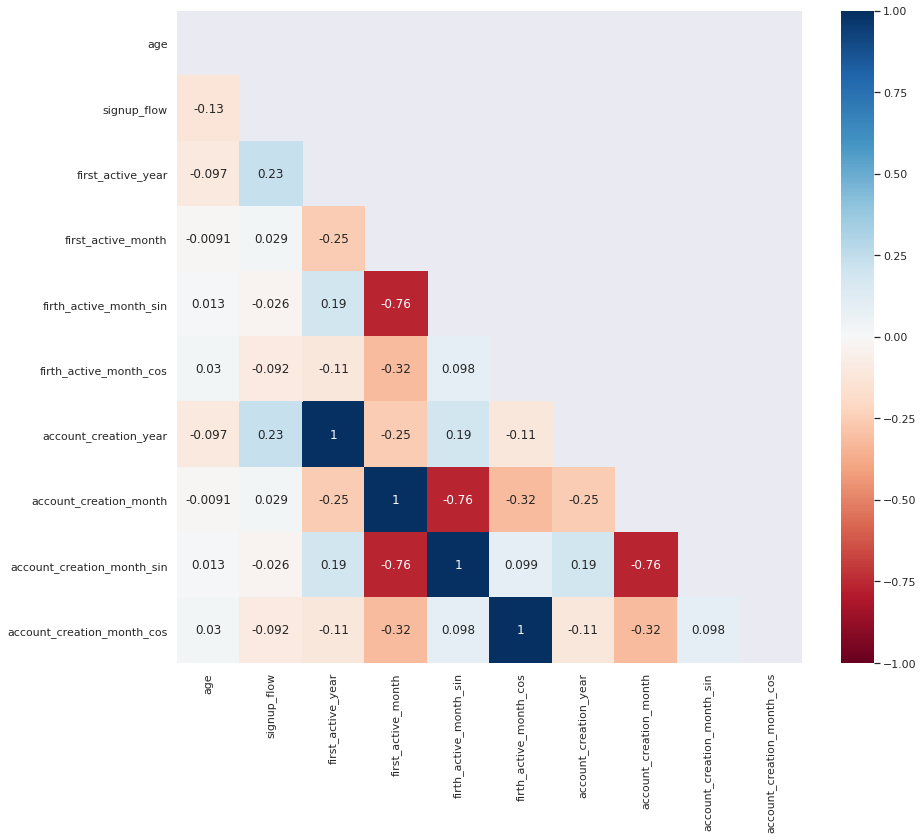

time: 757 ms


In [0]:
# heatmap senza dummy
sns.set(rc={'figure.figsize':(14,12)})
corrMatrix = all_data.corr()
sns.heatmap(corrMatrix, annot=True, vmin = -1, vmax = 1,cmap = 'RdBu',mask = np.triu(np.ones_like(corrMatrix, dtype=np.bool)))

account_creation e first_active sono fortemente correlati

Vengono eliminate tutte le variabile create da first_active

In [0]:
all_data.drop(columns = ['account_creation_month', 'first_active_year', 'first_active_month', 'firth_active_month_sin', 'firth_active_month_cos'], inplace = True)

### df_session

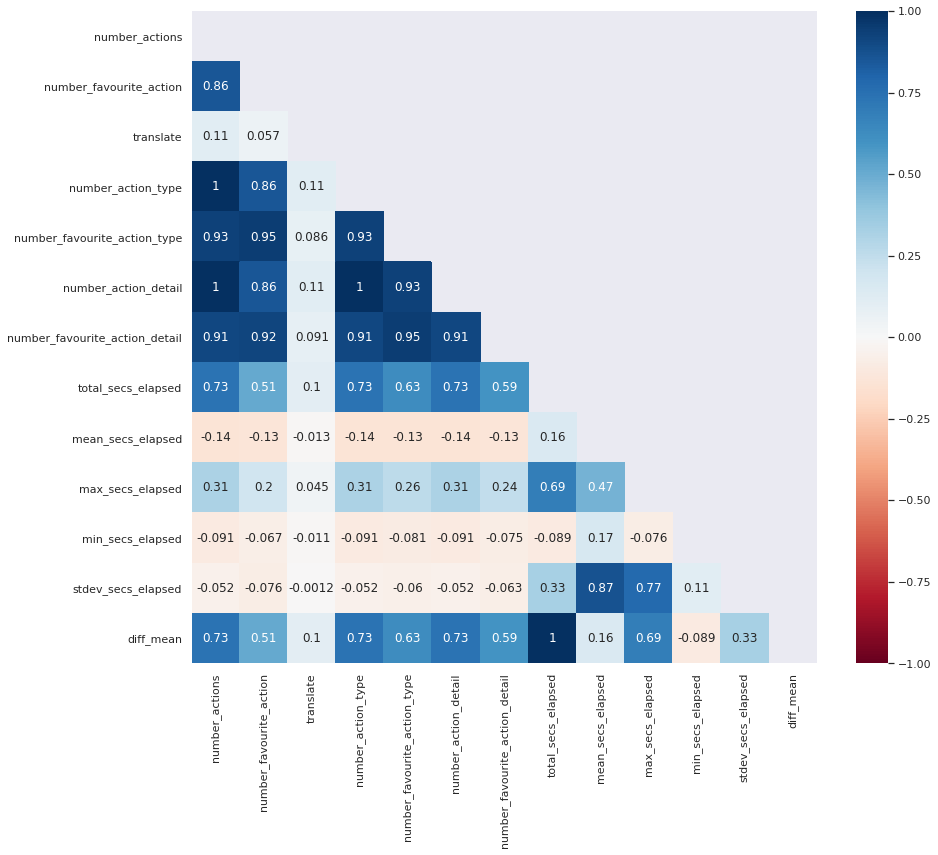

time: 871 ms


In [0]:
# heatmap senza dummy
sns.set(rc={'figure.figsize':(14,12)})
corrMatrix = df_session.corr()
sns.heatmap(corrMatrix, annot=True, vmin = -1, vmax = 1, cmap = 'RdBu',mask = np.triu(np.ones_like(corrMatrix, dtype=np.bool)))

In [0]:
df_session.drop(columns = ['number_action_type', 'total_secs_elapsed','number_action_detail', 'number_favourite_action_detail', 'number_favourite_action_type'], inplace = True)

time: 20 ms


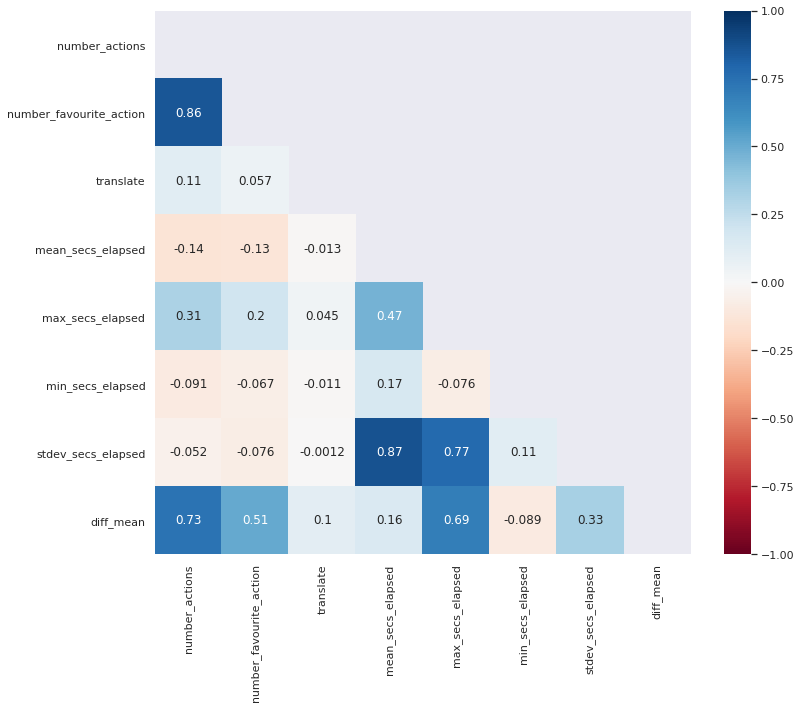

time: 504 ms


In [0]:
# heatmap senza dummy
sns.set(rc={'figure.figsize':(12,10)})
corrMatrix = df_session.corr()
sns.heatmap(corrMatrix, annot=True, vmin = -1, vmax = 1, cmap = 'RdBu', mask = np.triu(np.ones_like(corrMatrix, dtype=np.bool)))

# Preparazione dati

Unione dei due dataframe che sono stati preprocessati in precedenza sull'id degli utenti

In [0]:
df_nn = pd.merge(all_data, df_session, how = 'left', left_on = 'id', right_on = 'user_id')
df_nn.drop('user_id', axis = 1, inplace = True)
df_nn.head()

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,account_creation_year,account_creation_month_sin,account_creation_month_cos,number_actions,favourite_action,number_favourite_action,last_action,translate,favourite_action_type,last_action_type,favourite_action_detail,last_action_detail,favourite_device_type,mean_secs_elapsed,max_secs_elapsed,min_secs_elapsed,stdev_secs_elapsed,diff_mean
0,gxn3p5htnn,-unknown-,-1.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,2010,0.500000,-0.866025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,820tgsjxq7,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,2011,0.866025,-0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4ft3gnwmtx,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,2010,-0.866025,-0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bjjt8pjhuk,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,2011,-0.500000,0.866025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,87mebub9p4,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,2010,-0.866025,-0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


time: 740 ms


In [0]:
df_nn.fillna(-1, inplace = True)

# One Hot Encoding delle Categorial Features: 
categorical_features = ['gender',
                        'signup_method',
                        'language',
                        'affiliate_channel',
                        'affiliate_provider',
                        'first_affiliate_tracked',
                        'signup_app',
                        'first_device_type',
                        'first_browser',
                        'favourite_action',
                        'favourite_action_type', 
                        'last_action_type', 
                        'favourite_action_detail',
                        'last_action_detail', 
                        'favourite_device_type',
                        'last_action']

enc = LabelEncoder()
ohe_df = pd.DataFrame()
enc_df = pd.DataFrame()
for i in range(len(categorical_features)):
  if(len(df_nn[categorical_features[i]].value_counts()) <= 9):
    ohe_df = pd.concat([ohe_df, pd.get_dummies(df_nn[categorical_features[i]], drop_first = True)], axis = 1)
  else:
    df_nn[categorical_features[i]].replace(to_replace = -1, value = "null", inplace = True)
    col = pd.DataFrame(enc.fit_transform(df_nn[categorical_features[i]]), columns = [categorical_features[i]])
    enc_df = pd.concat([enc_df, col], axis = 1)

numerical_features = [df_nn.age,
                      df_nn.signup_flow,
                      df_nn.account_creation_year,
                      df_nn.account_creation_month_sin,
                      df_nn.account_creation_month_cos,
                      df_nn.number_actions,
                      df_nn.number_favourite_action,
                      df_nn.translate,
                      df_nn.mean_secs_elapsed,
                      df_nn.max_secs_elapsed,  
                      df_nn.min_secs_elapsed,
                      df_nn.stdev_secs_elapsed,
                      df_nn.diff_mean]

num_df = pd.concat(numerical_features, axis=1)
num_df = pd.concat([num_df, enc_df], axis = 1)

# normalizzazione
num_df=(num_df-num_df.min())/(num_df.max()-num_df.min())

time: 1.75 s


In [0]:
df = pd.concat([df_nn.id, num_df, ohe_df], axis=1)
df.head()

,id,age,signup_flow,account_creation_year,account_creation_month_sin,account_creation_month_cos,number_actions,number_favourite_action,translate,mean_secs_elapsed,max_secs_elapsed,min_secs_elapsed,stdev_secs_elapsed,diff_mean,language,affiliate_provider,first_browser,favourite_action,favourite_action_type,last_action_type,favourite_action_detail,last_action_detail,favourite_device_type,last_action,FEMALE,MALE,OTHER,facebook,google,weibo,content,direct,other,remarketing,sem-brand,sem-non-brand,seo,linked,local ops,marketing,omg,product,tracked-other,untracked,Moweb,Web,iOS,Android Tablet,Desktop (Other),Mac Desktop,Other/Unknown,SmartPhone (Other),Windows Desktop,iPad,iPhone
0,gxn3p5htnn,0.000000,0.00,0.00,0.750000,0.066987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039356,0.24,0.235294,0.148148,0.55914,0.666667,0.666667,0.526316,0.522727,1.0,0.5625,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0
1,820tgsjxq7,0.386139,0.00,0.25,0.933013,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039356,0.24,0.470588,0.148148,0.55914,0.666667,0.666667,0.526316,0.522727,1.0,0.5625,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0
2,4ft3gnwmtx,0.564356,0.12,0.00,0.066987,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039356,0.24,0.235294,0.407407,0.55914,0.666667,0.666667,0.526316,0.522727,1.0,0.5625,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
3,bjjt8pjhuk,0.425743,0.00,0.25,0.250000,0.933013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039356,0.24,0.235294,0.314815,0.55914,0.666667,0.666667,0.526316,0.522727,1.0,0.5625,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0
4,87mebub9p4,0.415842,0.00,0.00,0.066987,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039356,0.24,0.235294,0.148148,0.55914,0.666667,0.666667,0.526316,0.522727,1.0,0.5625,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0


time: 129 ms


In [0]:
# Separazione in train/test
new_train = df.iloc[:len(train)]
new_train.drop('id', axis = 1, inplace = True)
new_test = df.iloc[len(new_train):]

In [0]:
len(new_test)

62096

time: 3.43 ms


# Salvataggio dati e Caricamento dati

In [0]:
import pickle

# save data
'''file = open('/gdrive/My Drive/Advanced Machine Learning Project/Dati/dati.pkl', 'wb')
pickle.dump(df_nn, file)
pickle.dump(df, file)
pickle.dump(new_train, file)
pickle.dump(new_test, file)
pickle.dump(target_labels, file)
pickle.dump(le, file)
pickle.dump(train, file)
pickle.dump(test, file)
file.close()'''

# load data
file = open('/gdrive/My Drive/Advanced Machine Learning Project/Dati/dati.pkl', 'rb')
df_nn = pickle.load(file)
df = pickle.load(file)
new_train = pickle.load(file)
new_test = pickle.load(file)
target_labels = pickle.load(file)
le = pickle.load(file)
train = pickle.load(file)
test = pickle.load(file)

file.close()

time: 779 ms


# AutoML NN

In [0]:
x_train, x_test, y_train, y_test = train_test_split(new_train, target_labels, test_size = 0.2, random_state = 2020)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

nclasses = len(np.unique(target_labels))
nfeatures = np.size(x_train, axis=1)
target_labels_keras = to_categorical(target_labels)

time: 241 ms


In [0]:
# numero di neuroni
num_nodes1 = [1, nfeatures]
num_nodes2 = [1, nfeatures]
num_nodes3 = [1, nfeatures]

# DropOut
dropout_val = [0.05, 0.4]

# Adam optimizer
lr = [0.0001, 0.001]

param = {
        # numero di neuroni e strati
        'num_nodes1': ('int', num_nodes1),
        'num_nodes2': ('int', num_nodes2),
        'num_nodes3': ('int', num_nodes3),
        # Dropout
        'dropout_val': ('cont', dropout_val),
        # Adam optimizer
        'lr': ('cont', lr),
        }

col_name = list(param.keys())

time: 4.31 ms


In [0]:
es = EarlyStopping(monitor = 'val_loss',
                   mode = 'min',
                   patience = 8,
                   restore_best_weights = True)

# Definizione funzione per creazione rete neurale
def create_model_nn(num_nodes1,
                    num_nodes2,
                    num_nodes3,
                    dropout_val,
                    lr):

  # creazione modello
  model = Sequential()

  # strato input
  model.add(Dense(nfeatures,
                  activation= 'relu',
                  input_shape=(nfeatures,),
                  kernel_initializer = 'he_uniform'))
  model.add(Dropout(rate = dropout_val))

  # primo stato hidden
  model.add(Dense(int(num_nodes1),
                  activation= 'relu',
                  kernel_initializer = 'he_uniform'))
  model.add(Dropout(rate = dropout_val))

  # secondo stato hidden
  model.add(Dense(int(num_nodes2),
                  activation= 'relu',
                  kernel_initializer = 'he_uniform'))
  model.add(Dropout(rate = dropout_val))

  # terzo stato hidden
  model.add(Dense(int(num_nodes3),
                  activation= 'relu',
                  kernel_initializer = 'he_uniform'))
  model.add(Dropout(rate = dropout_val))
  
  # strato output
  model.add(Dense(12,
                  activation='softmax'))
  
  # compilazione della rete
  adam = keras.optimizers.adam(lr = lr)
  model.compile(optimizer= adam,
                loss='categorical_crossentropy',
                metrics=['top_k_categorical_accuracy'])
  return model

# Definzione modello per calcolo ndcg
def compute_ndcg(num_nodes1,
                 num_nodes2,
                 num_nodes3,
                 dropout_val,
                 lr):
  
  model = create_model_nn(num_nodes1,
                          num_nodes2,
                          num_nodes3,
                          dropout_val,
                          lr)
  
  network_history = model.fit(x = x_train, 
                             y = to_categorical(y_train),
                             batch_size = 128,
                             epochs = 200,
                             validation_split = 0.2,
                             verbose = 0,
                             callbacks = [es])
  
  # Plot di loss e top 5 accuracy
  def plot_history(network_history, x_plot):
      plt.figure()
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.plot(x_plot, network_history.history['loss'])
      plt.plot(x_plot, network_history.history['val_loss'])
      plt.legend(['Training', 'Validation'])

      plt.figure()
      plt.xlabel('Epochs')
      plt.ylabel('Accuracy')
      plt.plot(x_plot, network_history.history['top_k_categorical_accuracy'])
      plt.plot(x_plot, network_history.history['val_top_k_categorical_accuracy'])
      plt.legend(['Training', 'Validation'], loc='lower right')
      plt.show()

  %matplotlib inline
  x_plot = list(range(1,len(network_history.epoch)+1))
  plot_history(network_history, x_plot)

   # Funzioni per ndcg score
  def dcg_score(y_true, y_score, k=5):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    gain = 2 ** y_true - 1
    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

  def ndcg_score(ground_truth, predictions, k=5):
    lb = LabelBinarizer()
    lb.fit(range(len(predictions) + 1))
    T = lb.transform(ground_truth)
    scores = []
    for y_true, y_score in zip(T, predictions):
      actual = dcg_score(y_true, y_score, k)
      best = dcg_score(y_true, y_true, k)
      score = float(actual) / float(best)
      scores.append(score)
    return np.mean(scores)

  return_score = ndcg_score(y_test, model.predict_proba(x_test), k = 5)
  
  return return_score

time: 90.8 ms


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where










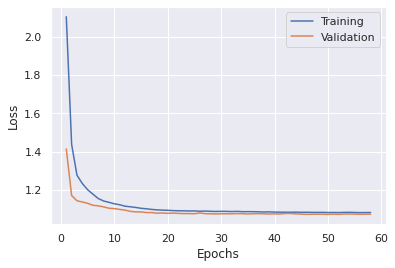

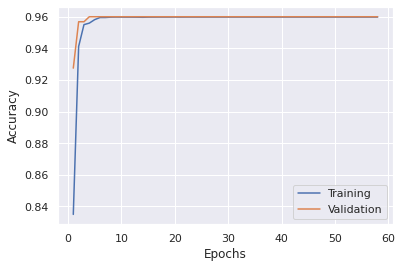

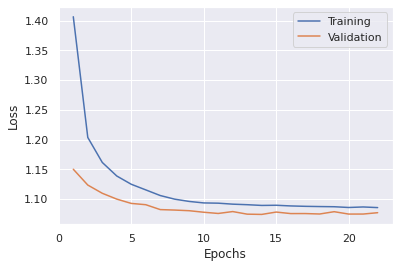

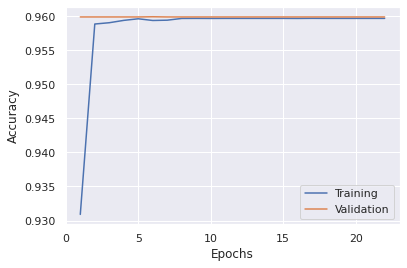

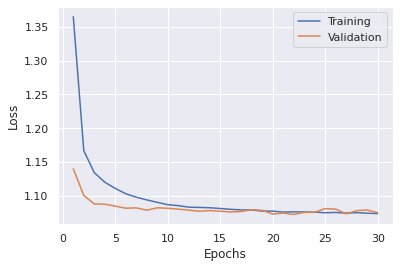

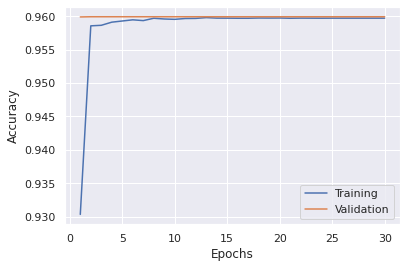

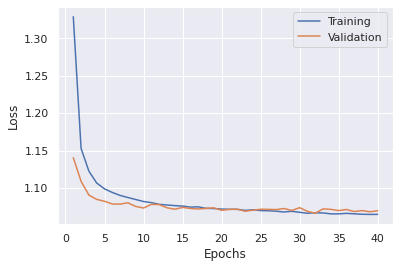

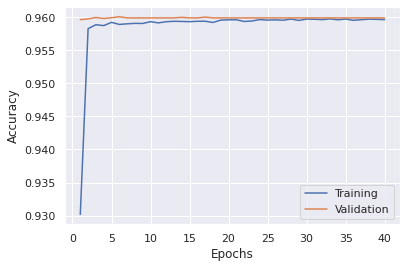

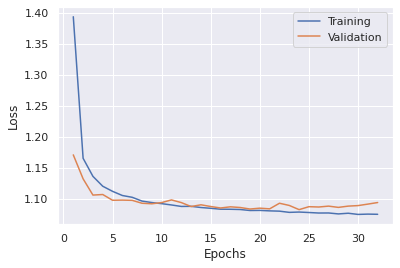

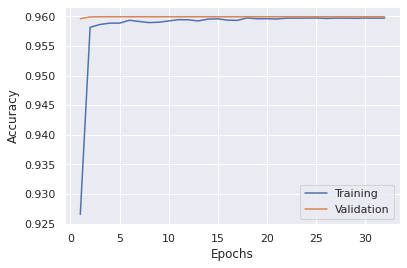

init   	 [3.30000000e+01 9.00000000e+00 4.00000000e+00 2.67541579e-01
 2.97867647e-04]. 	  0.8241973294685252 	 0.825226102730454
init   	 [3.10000000e+01 1.30000000e+01 7.00000000e+00 3.85029017e-01
 8.88389058e-04]. 	  0.8246555226019894 	 0.825226102730454
init   	 [1.70000000e+01 3.80000000e+01 1.40000000e+01 3.39059713e-01
 8.20056344e-04]. 	  0.8252174575769924 	 0.825226102730454
init   	 [2.80000000e+01 2.40000000e+01 4.80000000e+01 2.09929557e-01
 3.51307964e-04]. 	  0.825226102730454 	 0.825226102730454
init   	 [3.50000000e+01 7.00000000e+00 4.20000000e+01 3.02161233e-01
 4.07114001e-04]. 	  0.8248543611316057 	 0.825226102730454


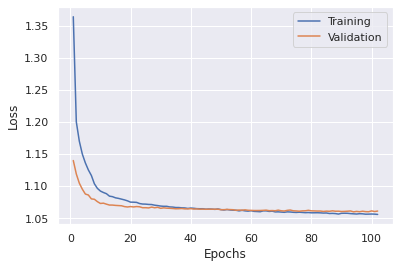

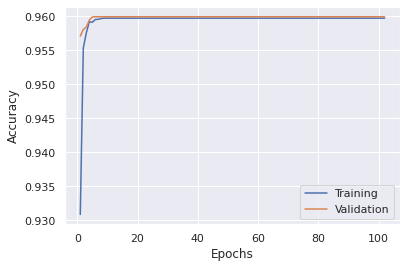

1      	 [3.00000000e+01 1.60000000e+01 3.00000000e+00 1.00430150e-01
 3.56287768e-04]. 	  0.8264160669911546 	 0.8264160669911546


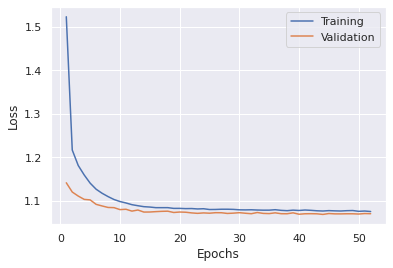

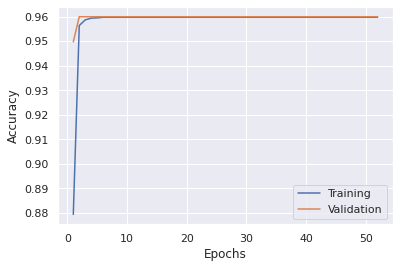

2      	 [3.07016532e+01 1.59999994e+01 2.29834782e+00 1.63970531e-01
 4.70701216e-04]. 	  0.8250186190473758 	 0.8264160669911546


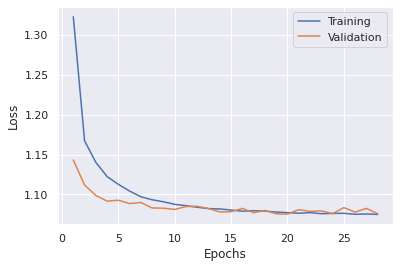

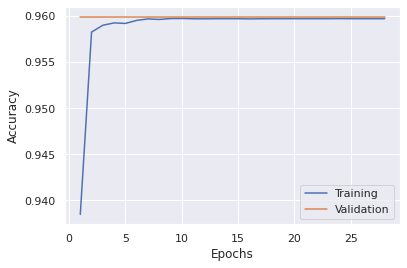

3      	 [1.61093233e+01 3.80000000e+01 1.35546615e+01 3.50723401e-01
 7.54316743e-04]. 	  0.8247765547504516 	 0.8264160669911546


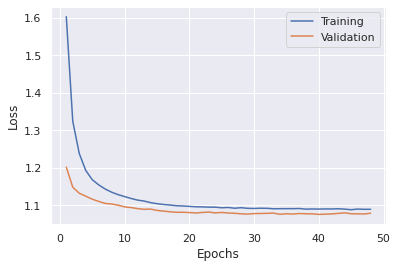

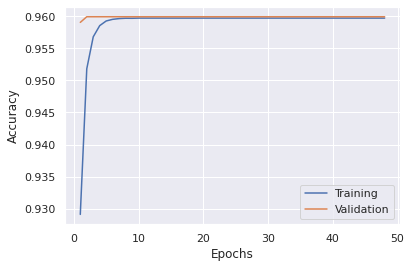

4      	 [3.36642932e+01 9.33214676e+00 3.33570883e+00 3.06066273e-01
 3.39083243e-04]. 	  0.807313344758049 	 0.8264160669911546


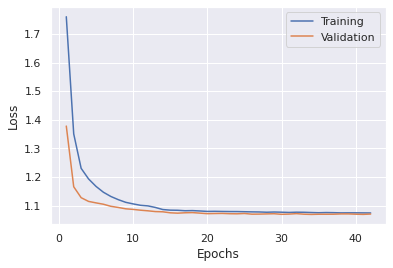

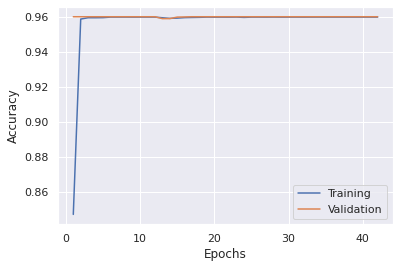

5      	 [3.03495258e+01 1.68505386e+01 2.65047834e+00 1.34255666e-01
 3.56454942e-04]. 	  0.8250877802750686 	 0.8264160669911546


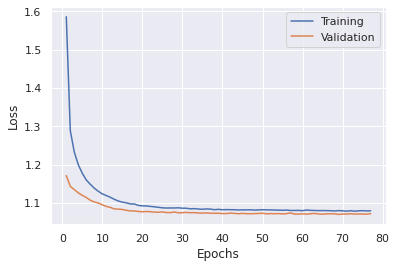

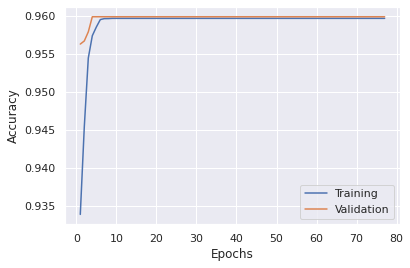

6      	 [3.38952273e+01 8.58464036e+00 3.96774733e+00 2.24320474e-01
 2.77969781e-04]. 	  0.8249753932800679 	 0.8264160669911546


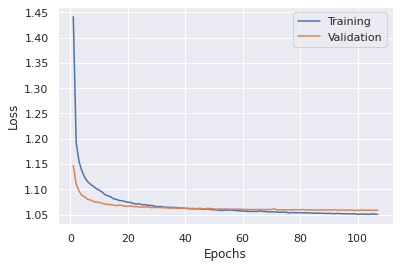

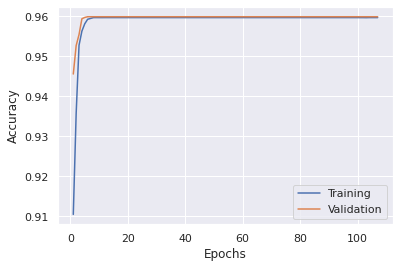

7      	 [3.09136734e+01 1.62792712e+01 3.20703561e+00 5.03014524e-02
 2.67460737e-04]. 	  0.8259522956212271 	 0.8264160669911546


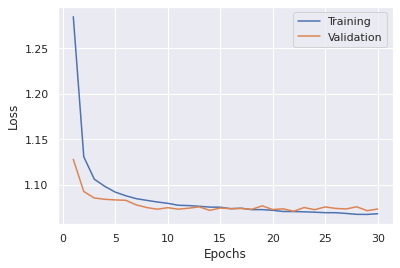

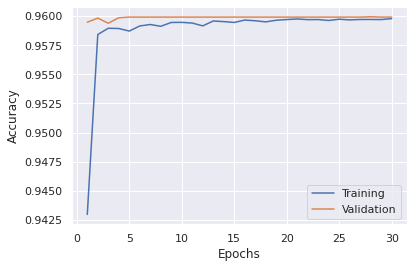

8      	 [3.42981528e+01 6.29815276e+00 4.20000000e+01 2.15371199e-01
 5.40813794e-04]. 	  0.8251840842640085 	 0.8264160669911546


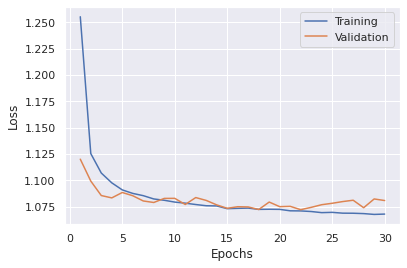

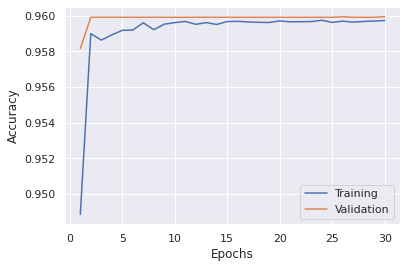

9      	 [3.41583319e+01 7.14085050e+00 4.24912591e+01 2.45326308e-01
 6.85544553e-04]. 	  0.8251310060423765 	 0.8264160669911546


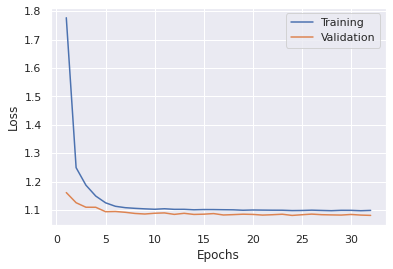

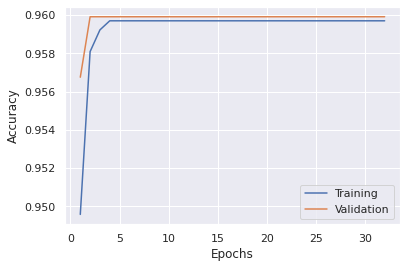

10     	 [3.50000000e+01 1.80000000e+01 1.00000000e+00 2.00535232e-01
 8.25514455e-04]. 	  0.807313344758049 	 0.8264160669911546


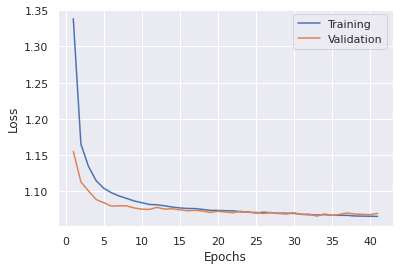

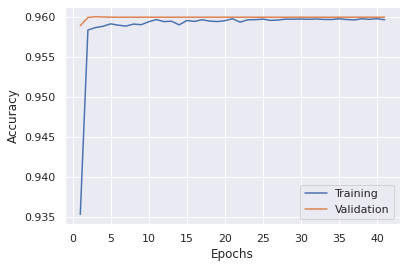

11     	 [2.80000000e+01 2.49660473e+01 4.77583961e+01 2.20748407e-01
 2.88395612e-04]. 	  0.8248543611316058 	 0.8264160669911546


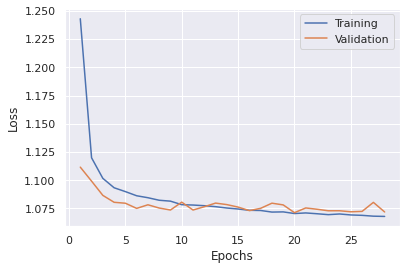

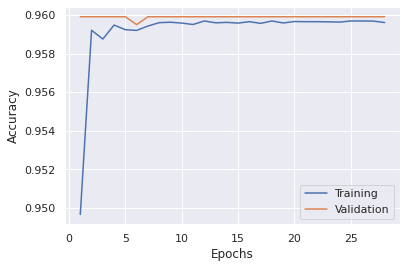

12     	 [3.41620822e+01 7.13589442e+00 4.15108407e+01 2.55569562e-01
 9.99988620e-04]. 	  0.8249840384335295 	 0.8264160669911546


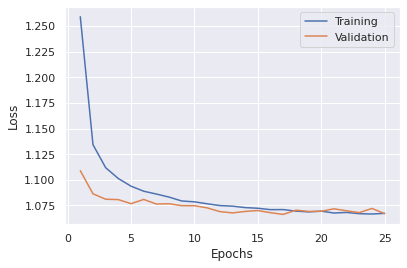

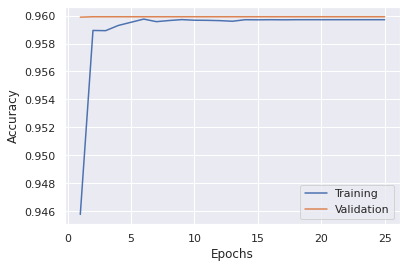

13     	 [1.90000000e+01 4.10000000e+01 1.10000000e+01 1.97864045e-01
 8.34156455e-04]. 	  0.8257793925519954 	 0.8264160669911546


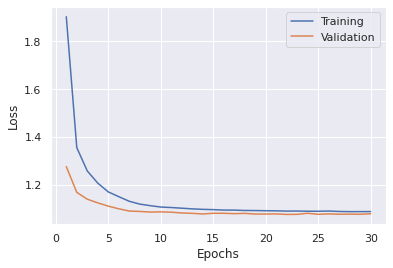

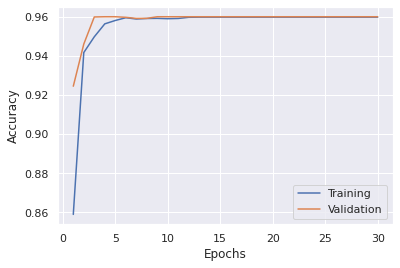

14     	 [3.37879394e+01 9.48994063e+00 4.31863034e+00 3.19291943e-01
 4.06451115e-04]. 	  0.8243961679981416 	 0.8264160669911546


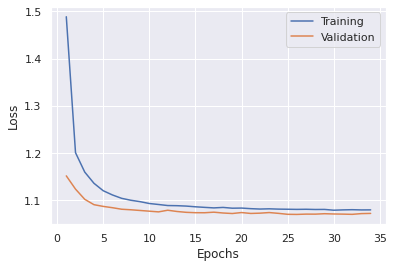

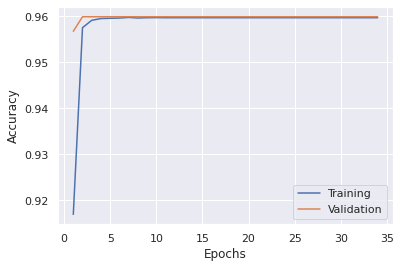

15     	 [3.04680681e+01 1.38006507e+01 7.26082642e+00 3.50262677e-01
 7.30186432e-04]. 	  0.8246987483692971 	 0.8264160669911546


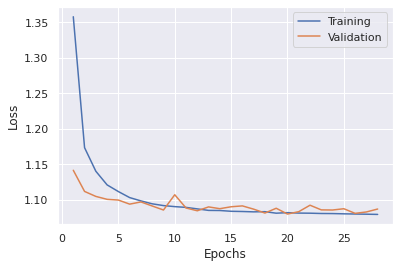

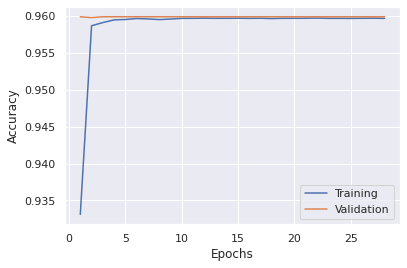

16     	 [1.63495792e+01 3.72851178e+01 1.41896507e+01 3.82228761e-01
 1.00000000e-03]. 	  0.8244134583050651 	 0.8264160669911546


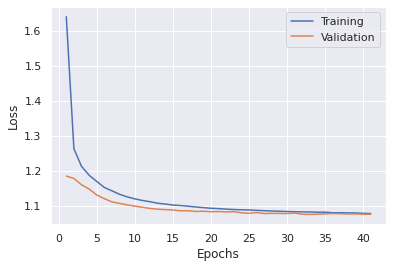

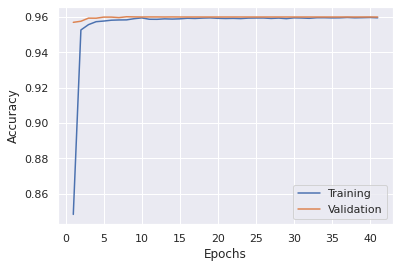

17     	 [2.83244311e+01 2.46733831e+01 4.86426196e+01 2.24426420e-01
 1.02966184e-04]. 	  0.824283781003141 	 0.8264160669911546


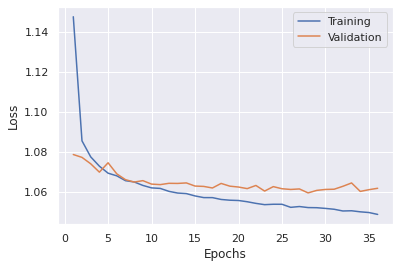

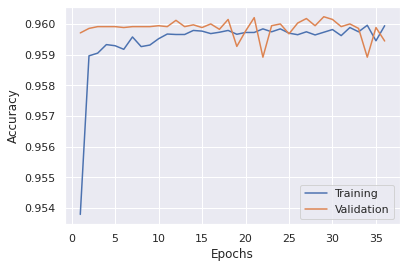

18     	 [3.44399689e+01 6.91208529e+00 4.19995921e+01 5.00000000e-02
 1.00000000e-03]. 	  0.8256895706510694 	 0.8264160669911546


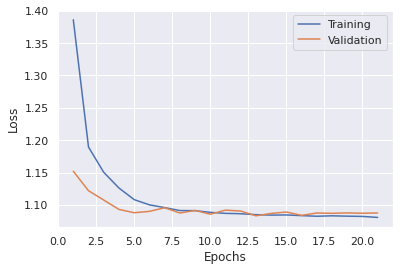

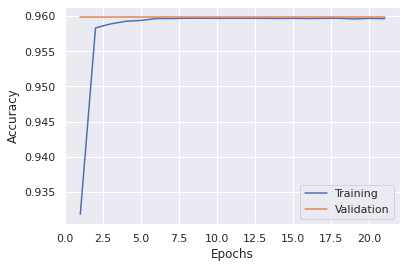

19     	 [1.61892524e+01 3.81983858e+01 1.45107734e+01 4.00000000e-01
 1.00000000e-03]. 	  0.8246728129089125 	 0.8264160669911546


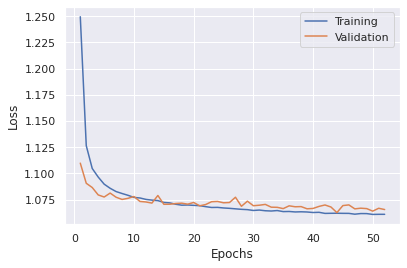

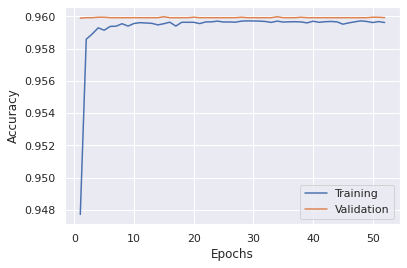

20     	 [2.88435626e+01 2.44712833e+01 4.78344076e+01 2.21142239e-01
 5.32919924e-04]. 	  0.825727521631226 	 0.8264160669911546
time: 2h 20min 1s


In [0]:
np.random.seed(2020)

kernel_covariance = squaredExponential()
surmodel = GaussianProcess(kernel_covariance)
acq = Acquisition(mode = "ExpectedImprovement")

SMBO = GPGO(surmodel, acq, compute_ndcg, param)
SMBO.run(init_evals = 5, max_iter = 20)

In [0]:
def df_out(parametri, ndcg_score, col_names):
  df = pd.DataFrame(parametri) 
  df.columns = col_names 
  df['ndcg_score'] = ndcg_score
  return df

time: 1.85 ms


In [0]:
risultati = df_out(SMBO.GP.X,SMBO.GP.y, col_name)
risultati

,num_nodes1,num_nodes2,num_nodes3,dropout_val,lr,ndcg_score
0,33.000000,9.000000,4.000000,0.267542,0.000298,0.824197
1,31.000000,13.000000,7.000000,0.385029,0.000888,0.824656
2,17.000000,38.000000,14.000000,0.339060,0.000820,0.825217
3,28.000000,24.000000,48.000000,0.209930,0.000351,0.825226
4,35.000000,7.000000,42.000000,0.302161,0.000407,0.824854
5,30.000000,16.000000,3.000000,0.100430,0.000356,0.826416
6,30.701653,15.999999,2.298348,0.163971,0.000471,0.825019
7,16.109323,38.000000,13.554661,0.350723,0.000754,0.824777
8,33.664293,9.332147,3.335709,0.306066,0.000339,0.807313
9,30.349526,16.850539,2.650478,0.134256,0.000356,0.825088


time: 52.4 ms


In [0]:
risultati.to_csv('/gdrive/My Drive/Advanced Machine Learning Project/risultati/result_nn.csv')

time: 9.7 s


## Best model NN

In [0]:
best_model = pd.read_csv('/gdrive/My Drive/Advanced Machine Learning Project/risultati/result_nn.csv', index_col = 0)

time: 9.79 ms


In [0]:
best_model = best_model.sort_values(by = 'ndcg_score', ascending = False).reset_index(drop = True)
best_model.head()

,num_nodes1,num_nodes2,num_nodes3,dropout_val,lr,ndcg_score
0,30.000000,16.000000,3.000000,0.100430,0.000356,0.826416
1,30.913673,16.279271,3.207036,0.050301,0.000267,0.825952
2,19.000000,41.000000,11.000000,0.197864,0.000834,0.825779
3,28.843563,24.471283,47.834408,0.221142,0.000533,0.825728
4,34.439969,6.912085,41.999592,0.050000,0.001000,0.825690


time: 23.5 ms


In [0]:
model = create_model_nn(best_model.num_nodes1[0],
                        best_model.num_nodes2[0],
                        best_model.num_nodes3[0],
                        best_model.dropout_val[0],
                        best_model.lr[0])
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_126 (Dense)            (None, 54)                2970      
_________________________________________________________________
dropout_101 (Dropout)        (None, 54)                0         
_________________________________________________________________
dense_127 (Dense)            (None, 30)                1650      
_________________________________________________________________
dropout_102 (Dropout)        (None, 30)                0         
_________________________________________________________________
dense_128 (Dense)            (None, 16)                496       
_________________________________________________________________
dropout_103 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_129 (Dense)            (None, 3)               

In [0]:
network_history = model.fit(x = x_train, 
                            y = to_categorical(y_train),
                            batch_size = 128,
                            epochs = 1000,
                            validation_split = 0.2,
                            verbose = 1,
                            callbacks = [es])

Train on 136608 samples, validate on 34152 samples
Epoch 1/1000
136608/136608 [==============================] - 12s 90us/step - loss: 1.6755 - top_k_categorical_accuracy: 0.8830 - val_loss: 1.2083 - val_top_k_categorical_accuracy: 0.9346
Epoch 2/1000
136608/136608 [==============================] - 8s 59us/step - loss: 1.2605 - top_k_categorical_accuracy: 0.9542 - val_loss: 1.1366 - val_top_k_categorical_accuracy: 0.9562
Epoch 3/1000
136608/136608 [==============================] - 8s 56us/step - loss: 1.2168 - top_k_categorical_accuracy: 0.9569 - val_loss: 1.1168 - val_top_k_categorical_accuracy: 0.9561
Epoch 4/1000
136608/136608 [==============================] - 7s 54us/step - loss: 1.1501 - top_k_categorical_accuracy: 0.9576 - val_loss: 1.0867 - val_top_k_categorical_accuracy: 0.9599
Epoch 5/1000
136608/136608 [==============================] - 8s 57us/step - loss: 1.1191 - top_k_categorical_accuracy: 0.9594 - val_loss: 1.0815 - val_top_k_categorical_accuracy: 0.9599
Epoch 6/1000


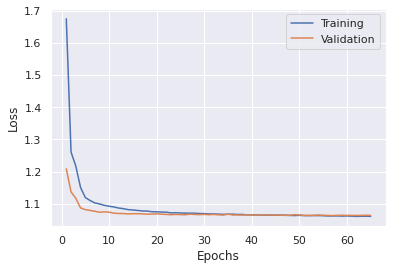

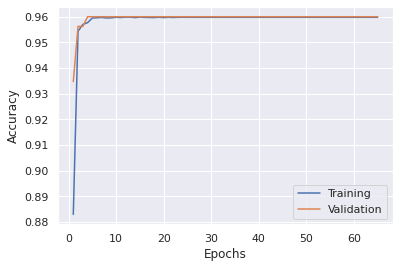

time: 691 ms


In [0]:
# Plot di loss e top 5 accuracy
def plot_history(network_history, x_plot):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['top_k_categorical_accuracy'])
    plt.plot(x_plot, network_history.history['val_top_k_categorical_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
%matplotlib inline
x_plot = list(range(1,len(network_history.epoch)+1))
plot_history(network_history, x_plot)

In [0]:
# Funzioni per ndcg score
def dcg_score(y_true, y_score, k=5):
  order = np.argsort(y_score)[::-1]
  y_true = np.take(y_true, order[:k])
  gain = 2 ** y_true - 1
  discounts = np.log2(np.arange(len(y_true)) + 2)
  return np.sum(gain / discounts)

def ndcg_score(ground_truth, predictions, k=5):
  lb = LabelBinarizer()
  lb.fit(range(len(predictions) + 1))
  T = lb.transform(ground_truth)
  scores = []
  for y_true, y_score in zip(T, predictions):
    actual = dcg_score(y_true, y_score, k)
    best = dcg_score(y_true, y_true, k)
    score = float(actual) / float(best)
    scores.append(score)
  return np.mean(scores)

time: 11.9 ms


In [0]:
ndcg_score(y_test, model.predict_proba(x_test), k = 5)

0.8259868762350736

time: 32.9 s


In [0]:
# save model
model.save('/gdrive/My Drive/Advanced Machine Learning Project/modelli_def/model_nn.h5')

time: 5.77 s


# AutoML XGBOOST

In [0]:
x_train, x_test, y_train, y_test = train_test_split(new_train, target_labels, test_size = 0.2, random_state = 2020)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

time: 201 ms


In [0]:
# Funzioni per ndcg score
def dcg_score(y_true, y_score, k=5):
  order = np.argsort(y_score)[::-1]
  y_true = np.take(y_true, order[:k])
  gain = 2 ** y_true - 1
  discounts = np.log2(np.arange(len(y_true)) + 2)
  return np.sum(gain / discounts)

def ndcg_score(ground_truth, predictions, k=5):
  lb = LabelBinarizer()
  lb.fit(range(len(predictions) + 1))
  T = lb.transform(ground_truth)
  scores = []
  for y_true, y_score in zip(T, predictions):
    actual = dcg_score(y_true, y_score, k)
    best = dcg_score(y_true, y_true, k)
    score = float(actual) / float(best)
    scores.append(score)
  return np.mean(scores)

time: 14.5 ms


In [0]:
# definizione degli iperparametri da ottimizzare
lr = [0,1]
gamma = [0,2]
max_depth = [3, 10]
n_estimators = [2, 10]
reg_alpha = [0, 1]

param_XG ={'lr': ('cont',lr),
           'gamma': ('cont', gamma),
           'max_depth':('int', max_depth),
           'n_estimators':('int', n_estimators),
           'reg_alpha': ('cont', reg_alpha)}

def compute_ndcg_cross(lr, gamma, max_depth, n_estimators, reg_alpha):
  # create model
  xgb = XGBClassifier(max_depth = int(max_depth),
                    learning_rate = lr,
                    n_estimators = int(n_estimators),
                    gamma = gamma,
                    objective = 'multi:softprob',
                    subsample = 0.6,
                    reg_alpha = reg_alpha)
  # fit model
  xgb.fit(x_train,
              y_train)
  
  # predict
  y_pred = xgb.predict_proba(x_test)

  # compute ndcg
  score = ndcg_score(y_test, xgb.predict_proba(x_test), k = 5)
  
  return score

col_name_XG = list(param_XG.keys())

time: 15.6 ms


In [0]:
np.random.seed(2020)

kernel_covariance = squaredExponential()
gp_modelsur = GaussianProcess(kernel_covariance)
fz_acquisition1=Acquisition(mode="ExpectedImprovement")

SMBO_xgb = GPGO(gp_modelsur, fz_acquisition1, compute_ndcg_cross, param_XG, n_jobs=1)
SMBO_xgb.run(init_evals=5, max_iter=20)

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.98627683 1.74678389 6.         5.         0.27183571]. 	  0.8226292513249794 	 0.8279195891038965
init   	 [0.33691873 0.43390853 3.         2.         0.34331559]. 	  0.8249248063795235 	 0.8279195891038965
init   	 [0.86215894 0.31339934 9.         5.         0.75708028]. 	  0.8238529117344096 	 0.8279195891038965
init   	 [0.73632492 0.71132618 9.         6.         0.66680305]. 	  0.8258015227913853 	 0.8279195891038965
init   	 [0.21710064 1.12285396 9.         7.         0.31973648]. 	  0.8279195891038965 	 0.8279195891038965
1      	 [0.         0.69497341 8.90184105 5.76616193 0.10946781]. 	  0.4592667351654231 	 0.8279195891038965
2      	 [1.         0.89114229 7.98295466 5.25423289 0.74637011]. 	  0.8232573923705186 	 0.8279195891038965
3      	 [0.6885836  1.33480366 8.15747343 6.5647519  0.55139886]. 	  0.8266602831645773 	 0.8279195891038965
4      	 [0.88188838 1.56256298 6.88377601 5.594477   0.332899

In [0]:
def df_out(parametri, ndcg_score, col_names):
  df = pd.DataFrame(parametri)
  df.columns = col_names
  df['ndcg_score'] = ndcg_score
  return df

time: 5.58 ms


In [0]:
risultati = df_out(SMBO_xgb.GP.X, SMBO_xgb.GP.y, col_name_XG)

time: 7.91 ms


In [0]:
risultati.to_csv('/gdrive/My Drive/Advanced Machine Learning Project/risultati/result_XGBOOST.csv')

time: 14.8 ms


## Best model XGBOOST

In [0]:
best_model = pd.read_csv('/gdrive/My Drive/Advanced Machine Learning Project/risultati/result_XGBOOST.csv', index_col = 0)

time: 13.8 ms


In [0]:
best_model = best_model.sort_values(by = 'ndcg_score', ascending = False).reset_index(drop = True)
best_model.head()

,lr,gamma,max_depth,n_estimators,reg_alpha,ndcg_score
0,0.369024,2.000000,8.662326,7.373869,0.472790,0.828071
1,0.296619,1.648045,8.901656,6.408483,1.000000,0.827970
2,0.217101,1.122854,9.000000,7.000000,0.319736,0.827920
3,0.380995,1.751605,7.893767,5.245707,0.644235,0.827748
4,0.264175,0.980245,8.347126,4.688585,1.000000,0.827571


time: 37.9 ms


In [0]:
xgb_model = XGBClassifier(max_depth = int(best_model.max_depth[0]), learning_rate = best_model.lr[0],
                         n_estimators = int(best_model.n_estimators[0]), gamma = best_model.gamma[0],
                         objective = 'multi:softprob', subsample = 0.6,
                         reg_alpha = best_model.reg_alpha[0])

time: 3.42 ms


In [0]:
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=2.0,
              learning_rate=0.3690242697174803, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=7, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0.4727901784568082, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.6, verbosity=1)

time: 1min


In [0]:
ndcg_score(y_test, xgb_model.predict_proba(x_test), k = 5)

0.8280709343531636

time: 31.1 s


In [0]:
# save model
file = open('/gdrive/My Drive/Advanced Machine Learning Project/modelli_def/xgb_model.pkl', 'wb')
pickle.dump(xgb_model, file)

time: 21 ms


# AutoML Random Forest

In [0]:
x_train, x_test, y_train, y_test = train_test_split(new_train, target_labels, test_size = 0.2, random_state = 2020)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

time: 188 ms


In [0]:
# Funzioni per ndcg score
def dcg_score(y_true, y_score, k=5):
  order = np.argsort(y_score)[::-1]
  y_true = np.take(y_true, order[:k])
  gain = 2 ** y_true - 1
  discounts = np.log2(np.arange(len(y_true)) + 2)
  return np.sum(gain / discounts)

def ndcg_score(ground_truth, predictions, k=5):
  lb = LabelBinarizer()
  lb.fit(range(len(predictions) + 1))
  T = lb.transform(ground_truth)
  scores = []
  for y_true, y_score in zip(T, predictions):
    actual = dcg_score(y_true, y_score, k)
    best = dcg_score(y_true, y_true, k)
    score = float(actual) / float(best)
    scores.append(score)
  return np.mean(scores)

time: 8.87 ms


In [0]:
def compute_ndcg_cross_RF(n_estimators,max_depth):
  # create model
  rfc = RandomForestClassifier(n_estimators=int(n_estimators),
                               max_depth=int(max_depth))
  # fit model
  rfc.fit(x_train,y_train)
  # predict
  y_pred = rfc.predict_proba(x_test)

  # compute NDCG
  ris = ndcg_score(y_test, rfc.predict_proba(x_test), k = 5)
  return ris

time: 5.07 ms


In [0]:
# definizione iperparametri 
N_estimators = [100,500]
max_depth = [5,30]

parametri_RF = {'n_estimators': ('int',N_estimators) ,
                'max_depth': ('int', max_depth)}

col_name = list(parametri_RF.keys())

time: 4.46 ms


In [0]:
kernel_covariance = squaredExponential()
gp_modelsur = GaussianProcess(kernel_covariance)
fz_acquisition1=Acquisition(mode="ExpectedImprovement")

rf_modelsur = RandomForest()

time: 4.76 ms


In [0]:
np.random.seed(2020)

SMBO_rf = GPGO(gp_modelsur,fz_acquisition1,compute_ndcg_cross_RF,parametri_RF,n_jobs=1)
SMBO_rf.run(init_evals=5,max_iter=20)

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [452.  13.]. 	  0.8277223757034985 	 0.8277223757034985
init   	 [479.  19.]. 	  0.8269640614047866 	 0.8277223757034985
init   	 [174.  22.]. 	  0.8244853670765524 	 0.8277223757034985
init   	 [107.   8.]. 	  0.8201492237031107 	 0.8277223757034985
init   	 [479.  27.]. 	  0.8206636872194624 	 0.8277223757034985
1      	 [479.          25.99737176]. 	  0.8225671345695709 	 0.8277223757034985
2      	 [479.          19.99443143]. 	  0.8273569377227459 	 0.8277223757034985
3      	 [478.15077261  19.49769192]. 	  0.8269347754363592 	 0.8277223757034985
4      	 [452.7024772   13.70248062]. 	  0.8280254318931054 	 0.8280254318931054
5      	 [111.  11.]. 	  0.8271919315048237 	 0.8280254318931054
6      	 [110.20692378  10.39775276]. 	  0.8254639267184636 	 0.8280254318931054
7      	 [479.85565527  26.49637209]. 	  0.8216721850757513 	 0.8280254318931054
8      	 [452.95157933  12.75142638]. 	  0.8270890342059652 	 0.82

In [0]:
risultati = df_out(SMBO_rf.GP.X,SMBO_rf.GP.y, col_name)
risultati.to_csv('/gdrive/My Drive/Advanced Machine Learning Project/risultati/ris_RF_autoML.csv')

time: 583 ms


### Best model Random Forest

In [0]:
best_model = pd.read_csv('/gdrive/My Drive/Advanced Machine Learning Project/risultati/ris_RF_autoML.csv')
par_best = best_model.sort_values(by='ndcg_score',ascending=False)
n_estimators_best = int(par_best.iloc[0]['n_estimators'])
max_depth_best = int(par_best.iloc[0]['max_depth'])

n_estimators_best, max_depth_best

(451, 14)

time: 34.5 ms


In [0]:
rf_best = RandomForestClassifier(n_estimators=n_estimators_best,max_depth=max_depth_best)
rf_best.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=14, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=451,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

time: 1min 54s


In [0]:
file = open('/gdrive/My Drive/Advanced Machine Learning Project/modelli_def/rf_model.pkl','wb')
pickle.dump(rf_best,file)

time: 7.62 s


# AutoML KNN

In [0]:
def compute_ndcg_cross_KNN(k):
  knn = KNeighborsClassifier(n_neighbors=int(k))
  knn_addestrato = knn.fit(x_train, y_train)
  y_pred = knn_addestrato.predict_proba(x_test)
  ris = ndcg_score(y_test, knn_addestrato.predict_proba(x_test), k = 5)
  return ris

time: 2.58 ms


In [0]:
#parametri
range_k = [50,200]
param ={'k': ('int',range_k)}

col_name =  list(param.keys())

time: 3.1 ms


In [0]:
kernel_covariance = squaredExponential()
gp_modelsur = GaussianProcess(kernel_covariance)
fz_acquisition1=Acquisition(mode="ExpectedImprovement")

rf_modelsur = RandomForest()

time: 3.66 ms


In [0]:
np.random.seed(2020)

SMBO_knn = GPGO(rf_modelsur,fz_acquisition1,compute_ndcg_cross_KNN,param,n_jobs=1)
SMBO_knn.run(init_evals=5, max_iter=20)

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [146.]. 	  0.8149570022513009 	 0.815353034309766
init   	 [186.]. 	  0.8139561439391498 	 0.815353034309766
init   	 [117.]. 	  0.815353034309766 	 0.815353034309766
init   	 [168.]. 	  0.8146620884117602 	 0.815353034309766
init   	 [141.]. 	  0.8152525577795146 	 0.815353034309766
1      	 [169.]. 	  0.814742655182534 	 0.815353034309766
2      	 [197.]. 	  0.8144350232726002 	 0.815353034309766
3      	 [55.]. 	  0.8132562091667032 	 0.815353034309766
4      	 [90.]. 	  0.8147855190432851 	 0.815353034309766
5      	 [60.]. 	  0.8132856318044033 	 0.815353034309766
6      	 [83.]. 	  0.8143168525855797 	 0.815353034309766
7      	 [75.]. 	  0.8141733423120592 	 0.815353034309766
8      	 [88.]. 	  0.8145762755240638 	 0.815353034309766
9      	 [168.]. 	  0.8146620884117602 	 0.815353034309766
10     	 [68.]. 	  0.8139252770680462 	 0.815353034309766
11     	 [196.]. 	  0.8142993638771505 	 0.815353034309766
12     

In [0]:
risultati = df_out(SMBO_knn.GP.X, SMBO_knn.GP.y, col_name)
risultati

risultati.to_csv('/gdrive/My Drive/Advanced Machine Learning Project/risultati/ris_KNN_autoML.csv')

time: 331 ms


###  Save best model

In [0]:
best_model = pd.read_csv('/gdrive/My Drive/Advanced Machine Learning Project/risultati/ris_KNN_autoML.csv', index_col = 0)
par_best = best_model.sort_values(by='ndcg_score',ascending=False)

time: 16.1 ms


In [0]:
knn_best = KNeighborsClassifier(n_neighbors=int(par_best.k[0]))
knn_best.fit(x_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=146, p=2,
                     weights='uniform')

time: 20.1 s


In [0]:
file = open('/gdrive/My Drive/Advanced Machine Learning Project/modelli_def/knn_model.pkl','wb')
pickle.dump(knn_best,file)

time: 719 ms


# Confronto k-fold cross validation modelli

In [0]:
x_train, x_test, y_train, y_test = train_test_split(new_train, target_labels, test_size = 0.2, random_state = 2020)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

time: 140 ms


In [0]:
# Funzioni per ndcg score
def dcg_score(y_true, y_score, k=5):
  order = np.argsort(y_score)[::-1]
  y_true = np.take(y_true, order[:k])
  gain = 2 ** y_true - 1
  discounts = np.log2(np.arange(len(y_true)) + 2)
  return np.sum(gain / discounts)

def ndcg_score(ground_truth, predictions, k=5):
  lb = LabelBinarizer()
  lb.fit(range(len(predictions) + 1))
  T = lb.transform(ground_truth)
  scores = []
  for y_true, y_score in zip(T, predictions):
    actual = dcg_score(y_true, y_score, k)
    best = dcg_score(y_true, y_true, k)
    score = float(actual) / float(best)
    scores.append(score)
  return np.mean(scores)

time: 10.6 ms


## NN

In [0]:
model_nn = load_model('/gdrive/My Drive/Advanced Machine Learning Project/modelli_def/model_nn.h5')





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


time: 986 ms


In [0]:
ndcg_score(y_test, model_nn.predict_proba(x_test), k = 5)

0.8259868762350736

time: 51.2 s


### Cross-validation

In [0]:
best_model_nn = pd.read_csv('/gdrive/My Drive/Advanced Machine Learning Project/risultati/result_nn.csv', index_col = 0)
best_model_nn = best_model_nn.sort_values(by = 'ndcg_score', ascending = False).reset_index(drop = True)

time: 9.66 ms


In [0]:
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
cvscores_nn = []

i = 1
for train, test in kfold.split(new_train, target_labels): 
  model_nn = create_model_nn(best_model_nn.num_nodes1[0],
                             best_model_nn.num_nodes2[0],
                             best_model_nn.num_nodes3[0],
                             best_model_nn.dropout_val[0],
                             best_model_nn.lr[0])
  # Fit
  model_nn.fit(x = new_train.iloc[train],
              y = to_categorical(target_labels.iloc[train]), 
              batch_size = 128,
              epochs = 1000,
              validation_split = 0.2,
              verbose = 0,
              callbacks = [es])
  
  # Valutazione
  scores = ndcg_score(target_labels.iloc[test],
                      model_nn.predict_proba(new_train.iloc[test]), k = 5)
  print('Iterazione numero: ' + str(i))
  print('NDCG score: ' + str(scores*100))
  cvscores_nn.append(scores * 100)
  i +=1

print("Score 10-CV neural network: " + "%.2f%% (+/- %.2f%%)" % (np.mean(cvscores_nn), np.std(cvscores_nn)))

Iterazione numero: 1
NDCG score: 82.64573388019882
Iterazione numero: 2
NDCG score: 82.47207371545426
Iterazione numero: 3
NDCG score: 82.18057859187195
Iterazione numero: 4
NDCG score: 82.6445498095872
Iterazione numero: 5
NDCG score: 82.3294302787908
Iterazione numero: 6
NDCG score: 82.76221449359912
Iterazione numero: 7
NDCG score: 82.556445481501
Iterazione numero: 8
NDCG score: 82.61825413914816
Iterazione numero: 9
NDCG score: 82.59818349387933
Iterazione numero: 10
NDCG score: 82.51090312410285
Score 10-CV neural network: 82.53% (+/- 0.16%)
time: 25min 6s


## XGBOOST

In [0]:
file = open('/gdrive/My Drive/Advanced Machine Learning Project/modelli_def/xgb_model.pkl', 'rb')
model_xgb = pickle.load(file)

time: 8.47 ms


In [0]:
ndcg_score(y_test, model_xgb.predict_proba(x_test), k = 5)

0.8280709343531636

time: 43.8 s


### Cross-validation

In [0]:
best_model_xgb = pd.read_csv('/gdrive/My Drive/Advanced Machine Learning Project/risultati/result_XGBOOST.csv', index_col = 0)
best_model_xgb = best_model_xgb.sort_values(by = 'ndcg_score', ascending = False).reset_index(drop = True)

time: 8.39 ms


In [0]:
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
cvscores_xgb = []

i = 1
for train, test in kfold.split(new_train, target_labels): 
  # create model
  model_xgb = XGBClassifier(max_depth = int(best_model_xgb.max_depth[0]), learning_rate = best_model_xgb.lr[0],
                           n_estimators = int(best_model_xgb.n_estimators[0]), gamma = best_model_xgb.gamma[0],
                           objective = 'multi:softprob', subsample = 0.6,
                           reg_alpha = best_model_xgb.reg_alpha[0])
  # fit 
  model_xgb.fit(new_train.iloc[train],
               target_labels.iloc[train])

  # Valutazione
  scores = ndcg_score(target_labels.iloc[test],
                      model_xgb.predict_proba(new_train.iloc[test]), k = 5)
  
  print('Iterazione numero: ' + str(i))
  print('NDCG score: ' + str(scores*100))
  cvscores_xgb.append(scores * 100)
  i +=1
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores_xgb), np.std(cvscores_xgb)))

Iterazione numero: 1
NDCG score: 82.97494378462052
Iterazione numero: 2
NDCG score: 82.85762611742898
Iterazione numero: 3
NDCG score: 82.56540406263484
Iterazione numero: 4
NDCG score: 82.92201881429399
Iterazione numero: 5
NDCG score: 82.60601998947004
Iterazione numero: 6
NDCG score: 83.03905957948128
Iterazione numero: 7
NDCG score: 82.72575066117591
Iterazione numero: 8
NDCG score: 83.03192753166671
Iterazione numero: 9
NDCG score: 82.84468750782939
Iterazione numero: 10
NDCG score: 82.89944549710539
82.85% (+/- 0.16%)
time: 14min 2s


## Random Forest

In [0]:
file = open('/gdrive/My Drive/Advanced Machine Learning Project/modelli_def/rf_model.pkl', 'rb')
model_rf = pickle.load(file)

time: 1.1 s


In [0]:
ndcg_score(y_test, model_rf.predict_proba(x_test), k = 5)

0.8286914539014127

time: 53.7 s


### Cross-validation

In [0]:
best_model_rf = pd.read_csv('/gdrive/My Drive/Advanced Machine Learning Project/risultati/ris_RF_autoML.csv', index_col = 0)
best_model_rf = best_model_rf.sort_values(by = 'ndcg_score', ascending = False).reset_index(drop = True)

time: 11.5 ms


In [0]:
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
cvscores_rf = []

i = 1
for train, test in kfold.split(new_train, target_labels): 
  # create model
  model_rf = RandomForestClassifier(n_estimators = int(best_model_rf.n_estimators[0]),
                                   max_depth = int(best_model_rf.max_depth[0]))
  # fit 
  model_rf.fit(new_train.iloc[train],
              target_labels.iloc[train])

  # Valutazione
  scores = ndcg_score(target_labels.iloc[test],
                      model_rf.predict_proba(new_train.iloc[test]), k = 5)
  
  print('Iterazione numero: ' + str(i))
  print('NDCG score: ' + str(scores*100))
  cvscores_rf.append(scores * 100)
  i +=1
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores_rf), np.std(cvscores_rf)))

Iterazione numero: 1
NDCG score: 82.83493329829912
Iterazione numero: 2
NDCG score: 82.63942978694139
Iterazione numero: 3
NDCG score: 82.50162334765807
Iterazione numero: 4
NDCG score: 82.88639887989471
Iterazione numero: 5
NDCG score: 82.59585693043697
Iterazione numero: 6
NDCG score: 83.04452127014143
Iterazione numero: 7
NDCG score: 82.81619064831611
Iterazione numero: 8
NDCG score: 82.92324622495109
Iterazione numero: 9
NDCG score: 82.91894870462976
Iterazione numero: 10
NDCG score: 82.89075274308968
82.81% (+/- 0.16%)
time: 25min 57s


## KNN

In [0]:
file = open('/gdrive/My Drive/Advanced Machine Learning Project/modelli_def/knn_model.pkl', 'rb')
model_knn = pickle.load(file)

time: 316 ms


In [0]:
ndcg_score(y_test, model_knn.predict_proba(x_test), k = 5)

0.8149570022513009

time: 9min 19s


### Cross-validation

In [0]:
best_model_knn = pd.read_csv('/gdrive/My Drive/Advanced Machine Learning Project/risultati/ris_KNN_autoML.csv', index_col = 0)
best_model_knn = best_model_knn.sort_values(by = 'ndcg_score', ascending = False).reset_index(drop = True)

time: 766 ms


In [0]:
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
cvscores_knn = []

i = 1
for train, test in kfold.split(new_train, target_labels): 
  # create model
  model_knn = KNeighborsClassifier(n_neighbors=int(best_model_knn.k[0]))
  # fit 
  model_knn.fit(new_train.iloc[train],
               target_labels.iloc[train])

  # Valutazione
  scores = ndcg_score(target_labels.iloc[test],
                      model_knn.predict_proba(new_train.iloc[test]), k = 5)
  
  print('Iterazione numero: ' + str(i))
  print('NDCG score: ' + str(scores*100))
  cvscores_knn.append(scores * 100)
  i +=1
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores_knn), np.std(cvscores_knn)))

Iterazione numero: 1
NDCG score: 81.55355335776045
Iterazione numero: 2
NDCG score: 81.32458478706411
Iterazione numero: 3
NDCG score: 81.14269292030426
Iterazione numero: 4
NDCG score: 81.5155271037656
Iterazione numero: 5
NDCG score: 81.1189749772934
Iterazione numero: 6
NDCG score: 81.74749575782249
Iterazione numero: 7
NDCG score: 81.53752999729002
Iterazione numero: 8
NDCG score: 81.65280269000141
Iterazione numero: 9
NDCG score: 81.60807461216389
Iterazione numero: 10
NDCG score: 81.55371657717791
81.48% (+/- 0.20%)
time: 40min 51s


# Ensemble Model

Creazione di un modello Ensemble a partire dai classificatori ottenuti in precedenza, la tecnica di Voting è la Average Voting

In [0]:
ris_rf = model_rf.predict_proba(x_test)
ris_nn = model_nn.predict_proba(x_test)
ris_xgb = model_xgb.predict_proba(x_test)
ris_knn = model_knn.predict_proba(x_test)

time: 6.16 s


In [0]:
ris_ensemble = np.array([ris_rf, ris_nn, ris_xgb])
ris_mean = np.mean(ris_ensemble, axis=0)

time: 9.3 ms


In [0]:
ndcg_score(y_test, ris_mean, k=5)

0.8288362976736992

time: 43.7 s


## Cross-validation

In [0]:
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
cvscores_ensemble = []

i = 1
for train, test in kfold.split(new_train, target_labels): 
  
  # Creazione e fit NN
  model_nn = create_model_nn(best_model_nn.num_nodes1[0],
                             best_model_nn.num_nodes2[0],
                             best_model_nn.num_nodes3[0],
                             best_model_nn.dropout_val[0],
                             best_model_nn.lr[0])
  
  model_nn.fit(x = new_train.iloc[train],
              y = to_categorical(target_labels.iloc[train]), 
              batch_size = 128,
              epochs = 1000,
              validation_split = 0.2,
              verbose = 0,
              callbacks = [es])
  
  # Creazione e fit XGBOOST
  model_xgb = XGBClassifier(max_depth = int(best_model_xgb.max_depth[0]), learning_rate = best_model_xgb.lr[0],
                           n_estimators = int(best_model_xgb.n_estimators[0]), gamma = best_model_xgb.gamma[0],
                           objective = 'multi:softprob', subsample = 0.6,
                           reg_alpha = best_model_xgb.reg_alpha[0])
  
  model_xgb.fit(new_train.iloc[train],
               target_labels.iloc[train])
  
  # Creazione e fit RANDOM FOREST
  model_rf = RandomForestClassifier(n_estimators = int(best_model_rf.n_estimators[0]),
                                   max_depth = int(best_model_rf.max_depth[0]))
  
  model_rf.fit(new_train.iloc[train],
              target_labels.iloc[train])
  
  # Creazione e fit KNN
  model_knn = KNeighborsClassifier(n_neighbors=int(best_model_knn.k[0]))

  model_knn.fit(new_train.iloc[train],
               target_labels.iloc[train])
  
  # Modello ensemble
  ris_rf = model_rf.predict_proba(new_train.iloc[test])
  ris_nn = model_nn.predict_proba(new_train.iloc[test])
  ris_xgb = model_xgb.predict_proba(new_train.iloc[test])
  ris_knn = model_knn.predict_proba(new_train.iloc[test])

  ris_ensemble = np.array([ris_rf, ris_nn, ris_xgb, ris_knn])
  ris_mean = np.mean(ris_ensemble, axis=0)

  # evaluate the model
  scores = ndcg_score(target_labels.iloc[test], ris_mean, k=5)
  
  print('Iterazione numero: ' + str(i))
  print('NDCG score: ' + str(scores*100))
  cvscores_ensemble.append(scores * 100)
  i +=1
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores_ensemble), np.std(cvscores_ensemble)))

Iterazione numero: 1
NDCG score: 82.76363238846042
Iterazione numero: 2
NDCG score: 82.53777212580069
Iterazione numero: 3
NDCG score: 82.357595697843
Iterazione numero: 4
NDCG score: 82.71849893435707
Iterazione numero: 5
NDCG score: 82.35048080383177
Iterazione numero: 6
NDCG score: 82.90511520452336
Iterazione numero: 7
NDCG score: 82.61312901843377
Iterazione numero: 8
NDCG score: 82.78987789126515
Iterazione numero: 9
NDCG score: 82.73552822716873
Iterazione numero: 10
NDCG score: 82.60495565162446
82.64% (+/- 0.17%)
time: 1h 39min 2s


# Feature importance

In [0]:
def importance(modello):
  interpreter = Interpretation(x_testsk, feature_names=df.columns)
  model = InMemoryModel(modello.predict_proba, examples=x_trainsk)
  valori = interpreter.feature_importance.feature_importance(model, n_jobs = 1)
  valori = valori.sort_values(ascending=True)
  dati = dict({"variabile":valori.index,
              "valori":valori.values})
  datidf = pd.DataFrame(dati)
  %matplotlib inline
  fig, ax = plt.subplots(figsize=(20, 20))
  ax.barh(datidf.variabile, datidf.valori)

time: 4.81 ms


In [0]:
# resemple per skater
df = pd.concat([new_train, target_labels], axis = 1)
df = resample(df, n_samples = 15000, random_state = 2020, replace = False, stratify = df)

target = df.target
df.drop("target", axis = 1, inplace=True)
x_trainsk, x_testsk, y_trainsk, y_testsk = train_test_split(df, target, random_state = 2020, shuffle = True, test_size = 0.2)

time: 14.9 s


## NN

2020-04-01 14:37:33,236 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False
2020-04-01 14:37:33,530 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[54/54] features ████████████████████ Time elapsed: 24 seconds

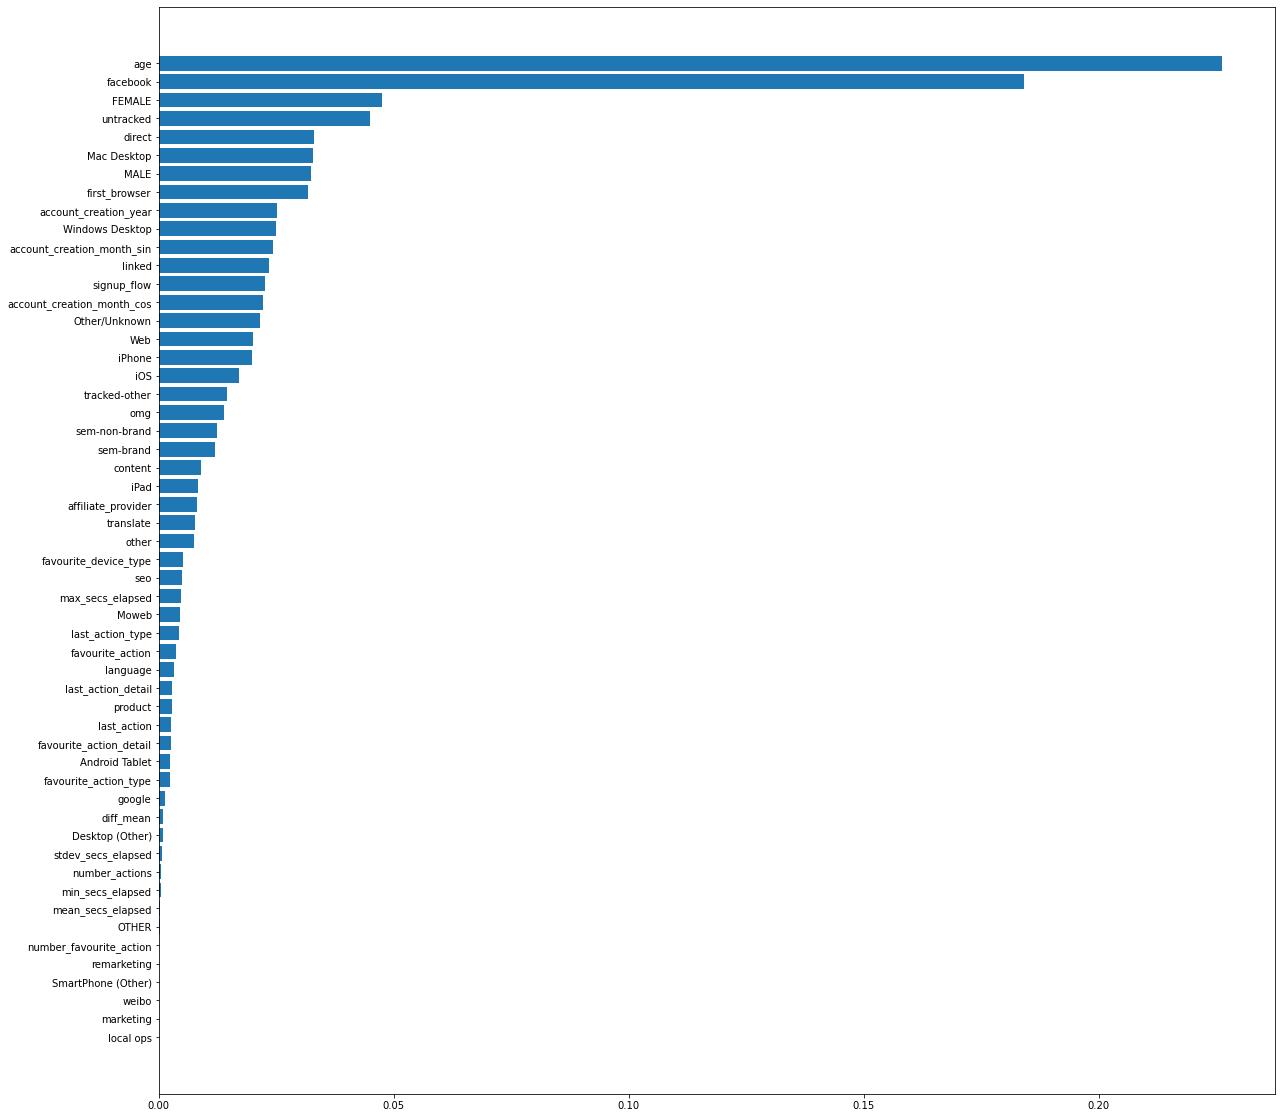

time: 57.3 s


In [0]:
model_nn_sk = create_model_nn(best_model_nn.num_nodes1[0],
                             best_model_nn.num_nodes2[0],
                             best_model_nn.num_nodes3[0],
                             best_model_nn.dropout_val[0],
                             best_model_nn.lr[0])

model_nn_sk.fit(x = x_trainsk,
              y = to_categorical(y_trainsk), 
              batch_size = 128,
              epochs = 1000,
              validation_split = 0.2,
              verbose = 0,
              callbacks = [es])

importance(model_nn_sk)

## XGBoost

2020-04-01 14:40:36,834 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False
2020-04-01 14:40:37,123 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[54/54] features ████████████████████ Time elapsed: 20 seconds

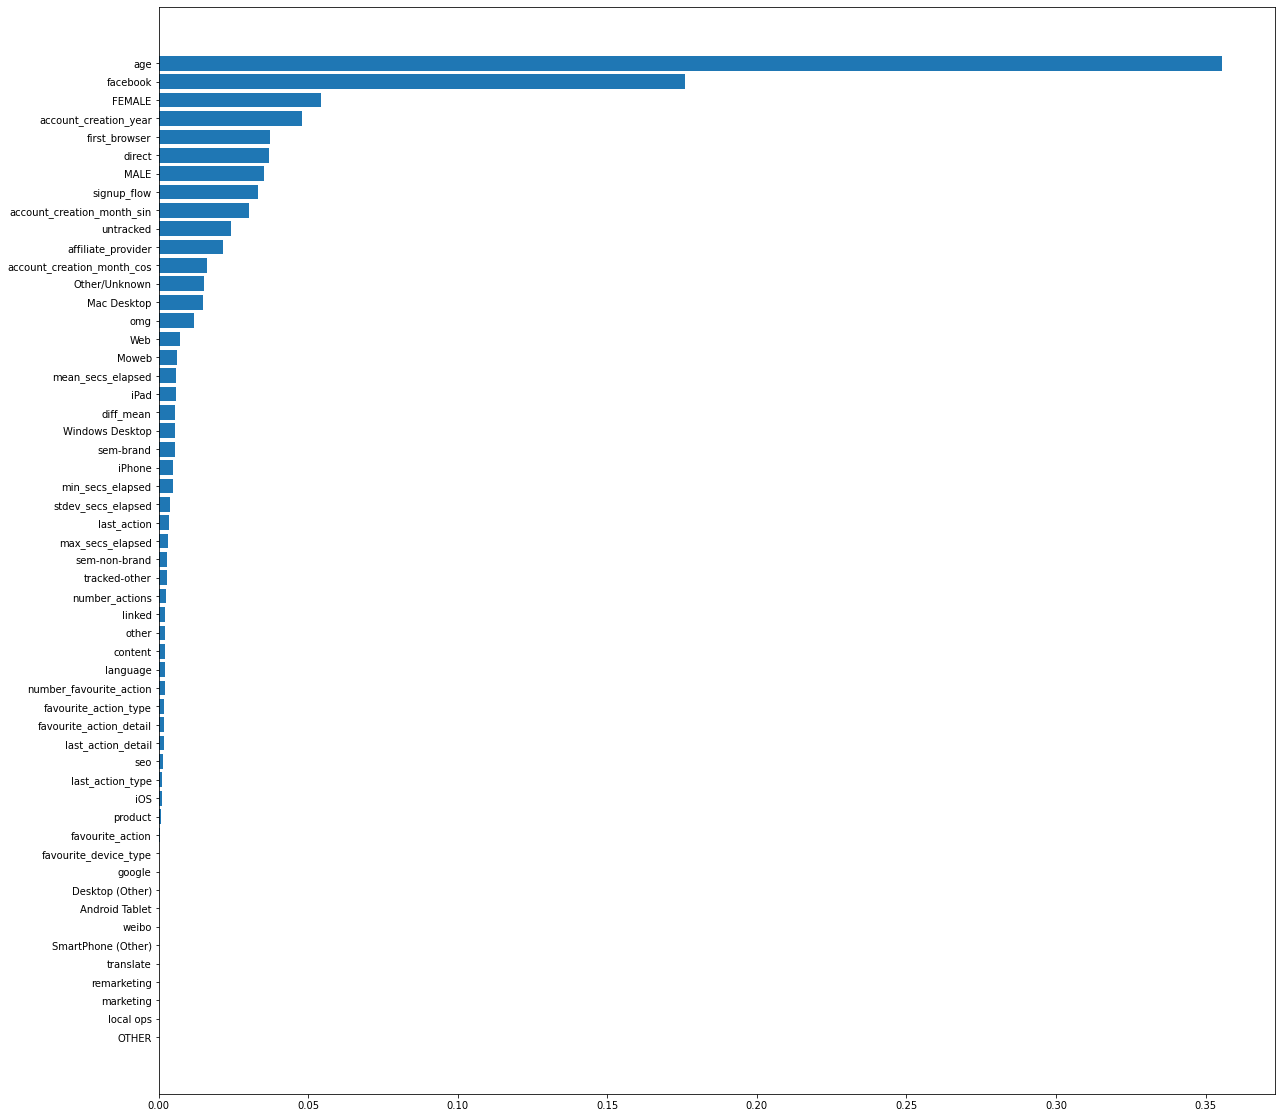

time: 24.1 s


In [0]:
# create model
model_xgb_sk = XGBClassifier(max_depth = int(best_model_xgb.max_depth[0]), learning_rate = best_model_xgb.lr[0],
                        n_estimators = int(best_model_xgb.n_estimators[0]), gamma = best_model_xgb.gamma[0],
                        objective = 'multi:softprob', subsample = 0.6,
                        reg_alpha = best_model_xgb.reg_alpha[0])
# fit model
model_xgb_sk.fit(x_trainsk,
                y_trainsk)

importance(model_xgb_sk)

## Random Forest

2020-04-01 14:42:51,284 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False
2020-04-01 14:42:51,567 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[54/54] features ████████████████████ Time elapsed: 36 seconds

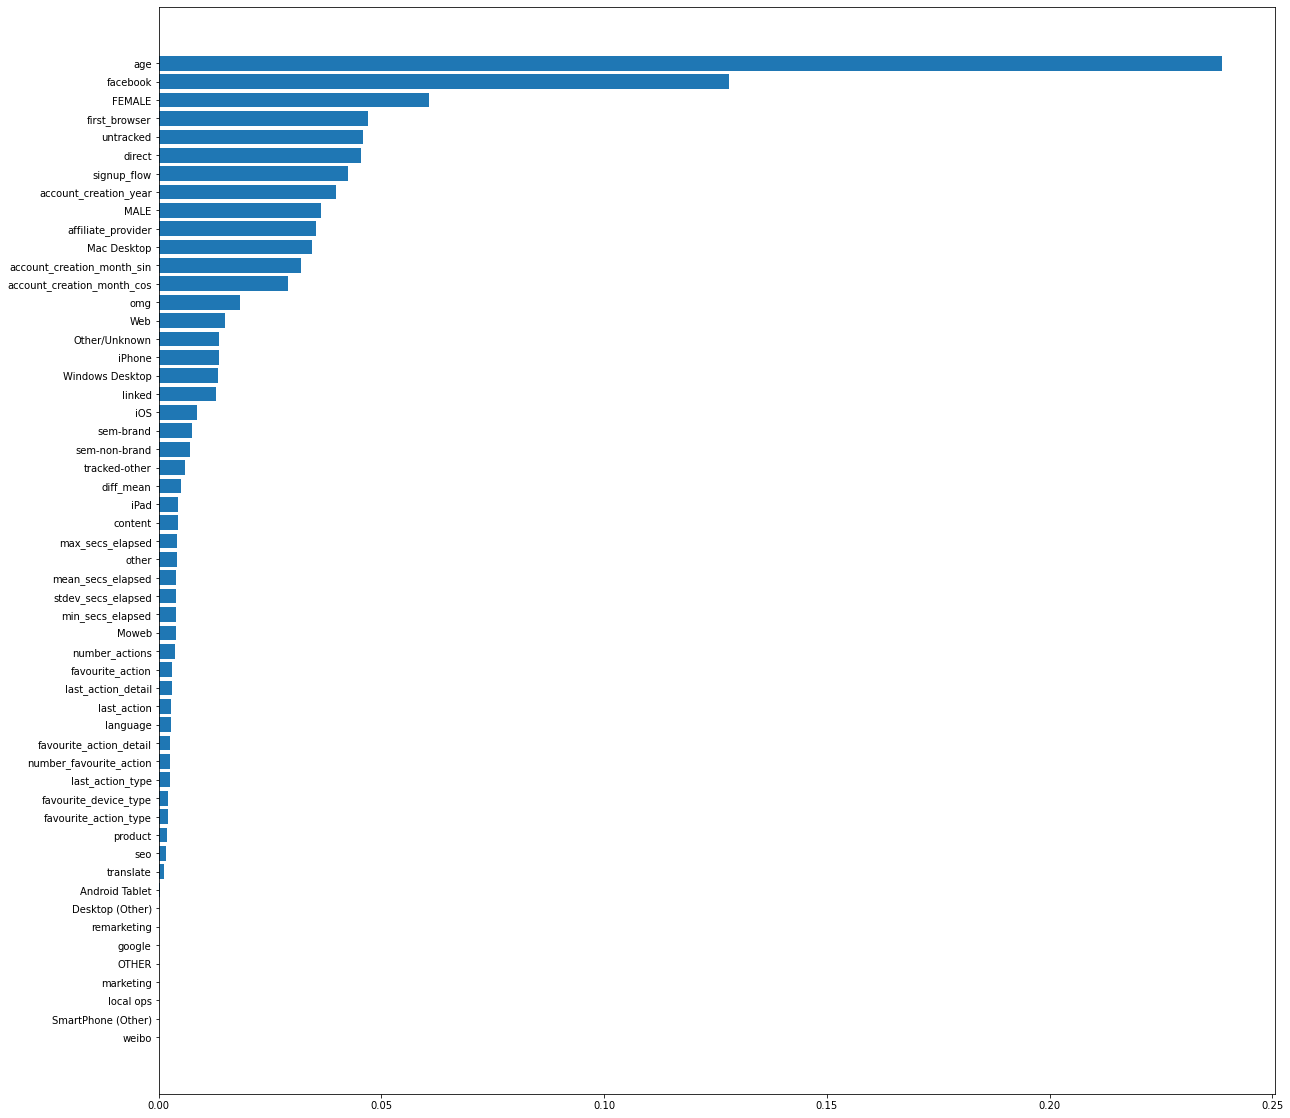

time: 44 s


In [0]:
model_rf_sk = RandomForestClassifier(n_estimators = int(best_model_rf.n_estimators[0]),
                                    max_depth = int(best_model_rf.max_depth[0]))
# fit model
model_rf_sk.fit(x_trainsk,
                y_trainsk)

importance(model_rf_sk)

## KNN

2020-04-01 14:44:07,669 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False
2020-04-01 14:44:07,953 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[54/54] features ████████████████████ Time elapsed: 162 seconds

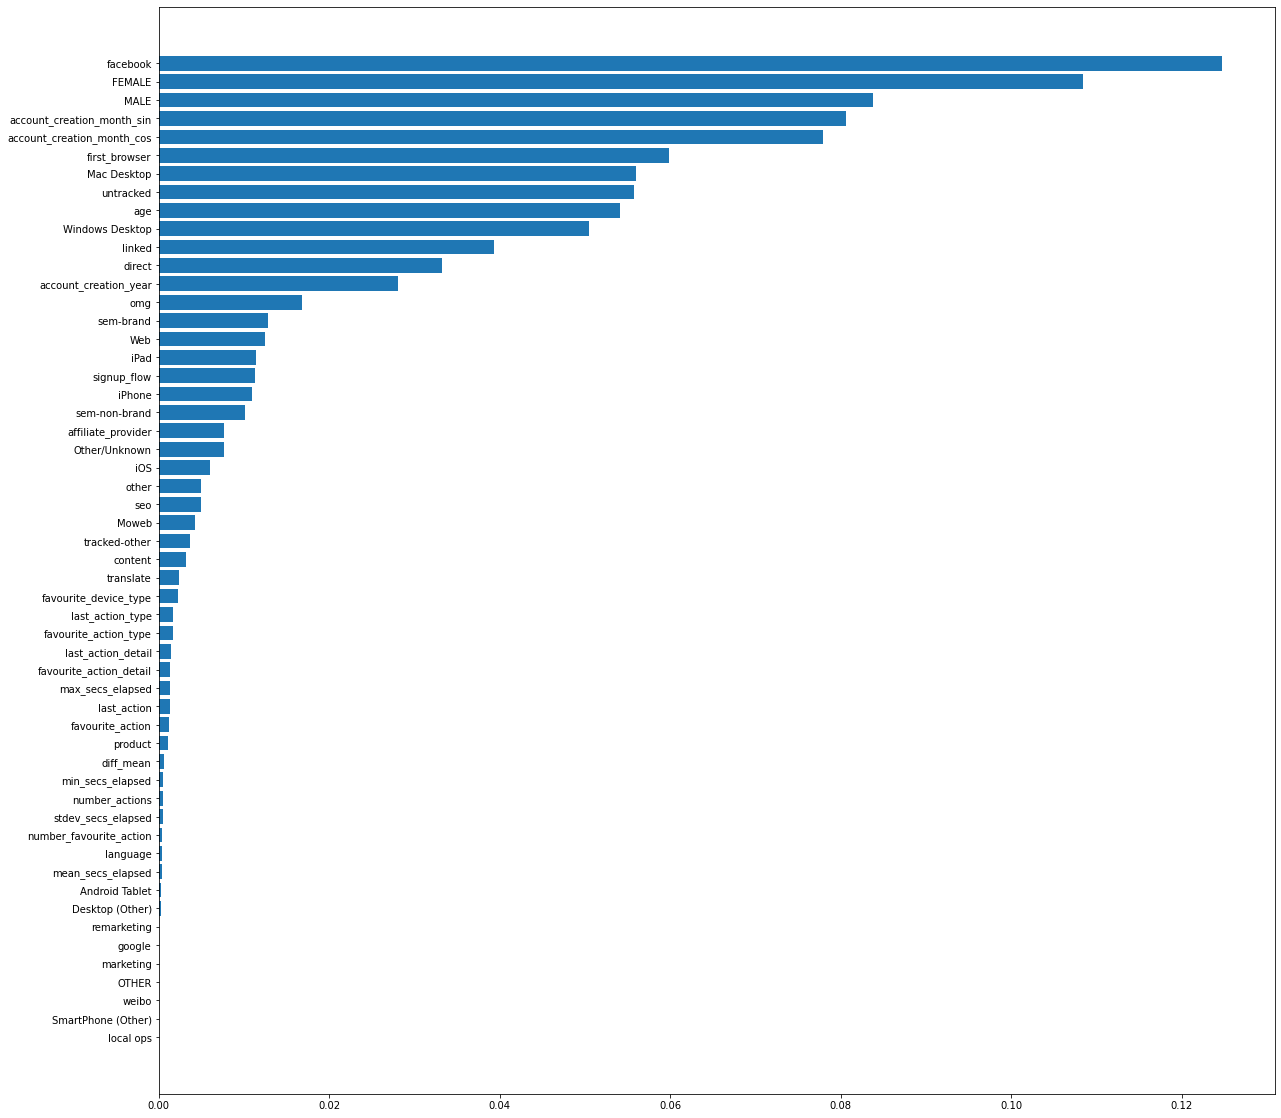

time: 3min 6s


In [0]:
# create model
model_knn_sk = KNeighborsClassifier(n_neighbors=int(best_model_knn.k[0]),leaf_size=int(best_model_knn.leaf_size[0]))
# fit model
model_knn_sk.fit(x_trainsk,
                y_trainsk)

importance(model_knn_sk)

# Kaggle submission

## Fit model su all data

In [0]:
to_train = np.array(new_train)
target = np.array(target_labels)

time: 97.9 ms


#### Neural network

In [0]:
best_model_nn = pd.read_csv('/gdrive/My Drive/Advanced Machine Learning Project/risultati/result_nn.csv', index_col = 0)
best_model_nn = best_model_nn.sort_values(by = 'ndcg_score', ascending = False).reset_index(drop = True)

time: 9.47 ms


In [0]:
# Create model
model_nn = create_model_nn(best_model_nn.num_nodes1[0],
                            best_model_nn.num_nodes2[0],
                            best_model_nn.num_nodes3[0],
                            best_model_nn.dropout_val[0],
                            best_model_nn.lr[0])
# Fit the model
model_nn.fit(x = to_train,
            y = to_categorical(target),
            batch_size = 128,
            epochs = 1000,
            validation_split = 0.2,
            verbose = 0,
            callbacks = [es])
  

time: 2min 15s


#### XGBoost

In [0]:
best_model_xgb = pd.read_csv('/gdrive/My Drive/Advanced Machine Learning Project/risultati/result_XGBOOST.csv', index_col = 0)
best_model_xgb = best_model_xgb.sort_values(by = 'ndcg_score', ascending = False).reset_index(drop = True)

time: 8.7 ms


In [0]:
# create model
model_xgb = XGBClassifier(max_depth = int(best_model_xgb.max_depth[0]), learning_rate = best_model_xgb.lr[0],
                          n_estimators = int(best_model_xgb.n_estimators[0]), gamma = best_model_xgb.gamma[0],
                          objective = 'multi:softprob', subsample = 0.6,
                          reg_alpha = best_model_xgb.reg_alpha[0])
# fit model
model_xgb.fit(to_train, target)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=2.0,
              learning_rate=0.3690242697174803, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=7, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0.4727901784568082, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.6, verbosity=1)

time: 1min 19s


#### Random Forest

In [0]:
best_model_rf = pd.read_csv('/gdrive/My Drive/Advanced Machine Learning Project/risultati/ris_RF_autoML.csv', index_col = 0)
best_model_rf = best_model_rf.sort_values(by = 'ndcg_score', ascending = False).reset_index(drop = True)

time: 8.84 ms


In [0]:
rf_best = RandomForestClassifier(n_estimators = int(best_model_rf.n_estimators[0]),
                                   max_depth = int(best_model_rf.max_depth[0]))
rf_best.fit(to_train, target)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=14, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=451,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

time: 2min 22s


#### KNN

In [0]:
best_model_knn = pd.read_csv('/gdrive/My Drive/Advanced Machine Learning Project/risultati/ris_KNN_autoML.csv', index_col = 0)
best_model_knn = best_model_knn.sort_values(by = 'ndcg_score', ascending = False).reset_index(drop = True)

time: 9.32 ms


In [0]:
# create model
model_knn = KNeighborsClassifier(n_neighbors=int(best_model_knn.k[0]))
# fit model
model_knn.fit(to_train, target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=117, p=2,
                     weights='uniform')

time: 43 s


## Submission

In [0]:
to_test = np.array(new_test.drop('id', axis = 1))

time: 34.3 ms


#### Neural Network

In [0]:
y_pred = model_nn.predict(to_test)
y_pred = np.flip(np.argsort(y_pred), axis=1)[:, :5]

time: 1.21 s


In [0]:
submission_nn = pd.concat([new_test.id.repeat(5).reset_index(drop=True), pd.Series(y_pred.ravel()).rename('country')], axis=1)
submission_nn['country'] = le.inverse_transform(submission_nn.country)

time: 39 ms


In [0]:
submission_nn.to_csv('submission_nn2.csv',index = False)

time: 370 ms


In [0]:
'''from google.colab import files
files.download("submission_nn.csv")'''

'from google.colab import files\nfiles.download("submission_nn.csv")'

time: 2.8 ms


In [0]:
!kaggle competitions submit -c airbnb-recruiting-new-user-bookings -f submission_nn2.csv -m "Message"

100% 4.38M/4.38M [00:05<00:00, 839kB/s]
Successfully submitted to Airbnb New User Bookingstime: 11.7 s


#### XGBoost

In [0]:
y_pred = model_xgb.predict_proba(to_test)
y_pred = np.flip(np.argsort(y_pred), axis=1)[:, :5]

time: 539 ms


In [0]:
submission_xgb = pd.concat([new_test.id.repeat(5).reset_index(drop=True), pd.Series(y_pred.ravel()).rename('country')], axis=1)
submission_xgb['country'] = le.inverse_transform(submission_xgb.country)

time: 41 ms


In [0]:
submission_xgb.to_csv('submission_xgb2.csv',index = False)

time: 371 ms


In [0]:
'''from google.colab import files
files.download("submission_xgb.csv")'''

'from google.colab import files\nfiles.download("submission_xgb.csv")'

time: 2.43 ms


In [0]:
!kaggle competitions submit -c airbnb-recruiting-new-user-bookings -f submission_xgb2.csv -m "Message"

100% 4.38M/4.38M [00:04<00:00, 983kB/s]
Successfully submitted to Airbnb New User Bookingstime: 8.23 s


#### Random Forest

In [0]:
y_pred = model_rf.predict_proba(to_test)
y_pred = np.flip(np.argsort(y_pred), axis=1)[:, :5]

time: 6.92 s


In [0]:
submission_rf = pd.concat([new_test.id.repeat(5).reset_index(drop=True), pd.Series(y_pred.ravel()).rename('country')], axis=1)
submission_rf['country'] = le.inverse_transform(submission_rf.country)

time: 39.5 ms


In [0]:
submission_rf.to_csv('submission_rf2.csv',index = False)

time: 369 ms


In [0]:
'''from google.colab import files
files.download("submission_rf.csv")'''

'from google.colab import files\nfiles.download("submission_rf.csv")'

time: 2.38 ms


In [0]:
!kaggle competitions submit -c airbnb-recruiting-new-user-bookings -f submission_rf2.csv -m "Message"

100% 4.38M/4.38M [00:05<00:00, 888kB/s]
Successfully submitted to Airbnb New User Bookingstime: 9.78 s


#### KNN

In [0]:
y_pred = model_knn.predict_proba(to_test)
y_pred = np.flip(np.argsort(y_pred), axis=1)[:, :5]

time: 13min 13s


In [0]:
submission_knn = pd.concat([new_test.id.repeat(5).reset_index(drop=True), pd.Series(y_pred.ravel()).rename('country')], axis=1)
submission_knn['country'] = le.inverse_transform(submission_knn.country)

time: 44.6 ms


In [0]:
submission_knn.to_csv('submission_knn2.csv',index = False)

time: 378 ms


In [0]:
'''from google.colab import files
files.download("submission_knn.csv")'''

'from google.colab import files\nfiles.download("submission_knn.csv")'

time: 2.45 ms


In [0]:
!kaggle competitions submit -c airbnb-recruiting-new-user-bookings -f submission_knn2.csv -m "Message"

100% 4.38M/4.38M [00:05<00:00, 808kB/s]
Successfully submitted to Airbnb New User Bookingstime: 10.2 s


#### Ensemble Model

In [0]:
y_pred_nn = model_nn.predict_proba(to_test)
y_pred_xgb = model_xgb.predict_proba(to_test)
y_pred_rf = model_rf.predict_proba(to_test)
y_pred_knn = model_knn.predict_proba(to_test)

ris_ensemble = np.array([y_pred_rf, y_pred_nn, y_pred_xgb, y_pred_knn])
y_pred_mean = np.mean(ris_ensemble, axis=0)

y_pred = np.flip(np.argsort(y_pred_mean), axis=1)[:, :5]

time: 13min 3s


In [0]:
submission_ensemble = pd.concat([new_test.id.repeat(5).reset_index(drop=True), pd.Series(y_pred.ravel()).rename('country')], axis=1)
submission_ensemble['country'] = le.inverse_transform(submission_ensemble.country)

time: 41 ms


In [0]:
submission_ensemble.to_csv('submission_ensemble_2.csv',index = False)

time: 379 ms


In [0]:
'''from google.colab import files
files.download("submission_ensemble.csv")'''

'from google.colab import files\nfiles.download("submission_ensemble.csv")'

time: 2.52 ms


In [0]:
!kaggle competitions submit -c airbnb-recruiting-new-user-bookings -f submission_ensemble_2.csv -m "Message"

100% 4.38M/4.38M [00:06<00:00, 762kB/s]
Successfully submitted to Airbnb New User Bookingstime: 11.8 s
